In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### **Importing all the needed libraries**

In [0]:
# import libraries needed
from collections import Counter
import pickle as pk
import warnings
import IPython
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, FunctionTransformer, LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
from pathlib import Path
import matplotlib.pyplot as plt
import itertools
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
# load original data (Standard Scaler method) into dataframe and check shape
db_data_pro = pd.read_csv('db_data_copy_complete_processed.csv')
print(db_data_pro.shape)

# read the unscaled data
db_data_unscaled = pd.read_csv('db_data_processed_wo_scaling.csv')
db_data_unscaled.drop(['patient_nbr','encounter_id'],axis =1,inplace=True)
#appying min max scaler
# Scaling numerical features
from sklearn.preprocessing import MinMaxScaler
num_cols = ['age','time_in_hospital','num_lab_procedures','num_medications',
            'num_procedures','num_lab_procedures_per_day','num_medications_per_day',
            'num_procedures_per_day','number_diagnoses','number_diagnoses_per_day',
            'total_num_procedures','total_num_lab_procedures','num_medications*num_procedures',
           'num_medications*num_lab_procedures','num_medications*number_diagnoses',
            'total_number_diagnoses']
features = db_data_unscaled[num_cols]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
db_data_unscaled[num_cols] = features

#save the min max- scaling data
db_data_unscaled.to_csv('db_data_minmax_new.csv')
# examine the data types and descriptive stats
#print(db_data_pro.info())
# print(db_data_pro.describe())
db_data_pro = db_data_unscaled.iloc[:,1:]
db_data_pro.groupby('readmitted').size().plot(kind='bar')
plt.ylabel('Count')

# Finding correlation
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(db_data_pro.corr())
db_data_pro.corr()

### **Here we made our various custom functions for evaluation paramteres, testing and training RMSE, plotting confusion matrix and ROC_auc curve etc.**

In [0]:
# Functions to be used thoroughout the code (created on our own)

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,f1_score

# function for evaluation parameters
def evaluate_model(y_actual, y_pred):
  ''' Return va Evaluation parameters for model
  Arguments
  ----------------
  y_actual:     Originial target feature of your dataset
  y_pred:       Predicted target feature of your dataset
  '''
  f1_score(y_actual, y_pred, average=None, labels=[0,1,2],zero_division=0)
  print(classification_report(y_actual,y_pred))
  print(confusion_matrix(y_actual,y_pred))
  acc_p = accuracy_score(y_actual,y_pred)
  print(f'Accuracy of Model is {acc_p}')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# function to calculate training RMSE
from sklearn.metrics import mean_squared_error
def calc_training_RMSE(X_train, y_train, model):
    '''returns the accuracy score and RMSE for trainig data 
    Arguments
    -----------------
    X_train:    Training dataset of your data
    y_train:    Trainig target feature of your data
    model:      Model after you are done with fitting
    '''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return model.score(X_train, y_train), rmse

# function to calculate testing RMSE 
def calc_test_RMSE(X_test, y_test, model):
    '''returns the score and RMSE for trainig data
    Arguments
    -----------------
    X_train:    Training dataset of your data
    y_train:    Trainig target feature of your data
    model:      Model after you are done with fitting
    '''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return model.score(X_test, y_test), rmse

# function for plotting ROC_AUC_CURVE for binary class classification
def make_roc_auc_curve(y_test,fit_model,model_name):
  '''plot roc_auc_curve for any model(binary_classification)
  Arguments
  -------------
  y_test = test data set of your data
  fit_model = the model after you are done with fitting data
  model_name = this is for the title of your graph for your model
  '''
  from sklearn.metrics import roc_auc_score
  # generate a no readmossion prediction (majority class)
  ns_probs = [0 for _ in range(len(y_test,))]

  # predict probabilities
  lr_probs = fit_model.predict_proba(y_test)
  # keep probabilities for the positive outcome only
  lr_probs = lr_probs[:, 1]
  # calculate scores
  ns_auc = roc_auc_score(y_test, ns_probs)
  lr_auc = roc_auc_score(y_test, lr_probs)
  # summarize scores
  print(f'No Readmission: ROC AUC=%.3f' % (ns_auc))
  print(f'{model_name}: ROC AUC=%.3f' % (lr_auc))
  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
  # plot the roc curve for the model
  pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Readmission')
  pyplot.plot(lr_fpr, lr_tpr, marker='.', label= model_name)
  # axis labels
  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')
  # show the legend
  pyplot.legend()
  # show the plot
  pyplot.show()
# function for ploting all socres in one figure
def make_confusion_matrix(cf,
                          y_true,
                          y_pred,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix with all important evaluation parameters
     using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    y_true:        your original target feature
    y_pred:        your predicted target feature
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''

    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = (np.trace(cf) / float(np.sum(cf))) * 100

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = precision_score(y_true,y_pred, average='weighted') * 100
            recall    = recall_score(y_true,y_pred, average='weighted') * 100
            f1_score  = 2*precision*recall / (precision + recall)
            roc_auc = roc_auc_score(y_true,y_pred) * 100
            stats_text = "\n\nAccuracy={:0.2f}%\nPrecision={:0.2f}%\nRecall={:0.2f}%\nF1 Score={:0.2f}%\nROC_AUC Score={:0.2f}%".format(
                accuracy,precision,recall,f1_score,roc_auc)
        else:
          #matrics for Multiclass classification
         
          precision = precision_score(y_true,y_pred, average='weighted') * 100
          recall = recall_score(y_true,y_pred, average='weighted') * 100
          f1_score = f1_score(y_true, y_pred, average='weighted') *100
          roc_auc = multiclass_roc_auc_score(y_true,y_pred) * 100
          stats_text = "\n\nAccuracy={:0.2f}%\nPrecision={:0.2f}%\nRecall={:0.2f}%\nF1 Score={:0.2f}%\nROC-AUC Score={:0.2f}%".format(
                accuracy,precision,recall,f1_score,roc_auc)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
# function to calculate multi class AUC_ROC acore  
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  '''
  This function will calculate roc_auc_score for multiclass classification
  Arguments
  ----------------------
  y_test:   test dataset of your data
  y_pred:   predicted target feature of your data 
  '''
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)

# Function for making curve for training RMSE and Test RMSE:
def make_learning_curve(X,y,model):
  from sklearn.model_selection import learning_curve

  train_sizes, train_scores, validation_scores = learning_curve(
  model,
  X ,
  y , train_sizes = train_sizes, cv = 5,
  scoring = 'neg_mean_squared_error')
  train_scores_mean = -train_scores.mean(axis = 1)
  validation_scores_mean = -validation_scores.mean(axis = 1)

  plt.style.use('seaborn')
  plt.plot(train_sizes, train_scores_mean, label = 'Training error')
  plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
  plt.ylabel('MSE', fontsize = 14)
  plt.xlabel('Training set size', fontsize = 14)
  plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
  plt.legend()
  plt.ylim(0,40)
#function for feature importance 
def feature_importance(fit_model,X_train,num_features, title=None):
    '''
    This function will plot the feature importance graph and returns the desired number of top score features
    Arguments
    -------------
    fit_model:    The model after you are done with fitting the data
    X_train:      Train dataset of your data
    num_features: The number of features you want to get 
    title:        Title of the figure
                  default:None otherwise it will print the given title
    '''
    importances = fit_model.feature_importances_
    feat_importances = 100.0 * (importances / importances.max())
    sorted_index = np.argsort(feat_importances)[::-1]
    feature_names = list(X_train.columns.values)
    feature_names_sort = [feature_names[indice] for indice in sorted_index]
    pos = np.arange(len(sorted_index)) + 15.0
    print (f'Top {num_features} features are: ')
    top = []
    for feature in feature_names_sort[:num_features]:
        print (feature)
        top.append(feature)
    # plot the result
    fig,ax = plt.subplots(figsize=(10,10))
    plt.bar(range(num_features), feat_importances[sorted_index[:num_features]])
    plt.yticks(np.arange(0, 101, 10)) 
    # Add feature names as x-axis labels
    plt.xticks(range(num_features), feature_names_sort[:num_features], rotation=90)

    ax.tick_params( width=7.5, colors='r',
                  grid_color='r', grid_alpha=0.5, labelsize = 'large')
    if title:
      plt.title('Relative Feature Importance : ' + title, fontsize=15)
    plt.show()
    return top



### **Read the processed data for modeling**

Text(0, 0.5, 'Count')

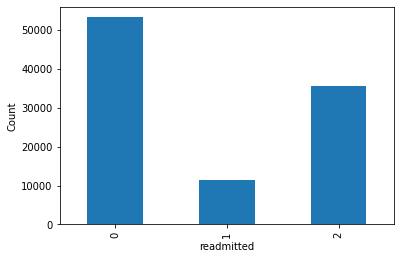

In [0]:
# read the scaled/normalized data for modeling    
db_data_pro = pd.read_csv('/content/drive/My Drive/db_data_minmax.csv')
db_data_pro = db_data_pro.iloc[:,2:]
db_data_pro.groupby('readmitted').size().plot(kind='bar')
plt.ylabel('Count')

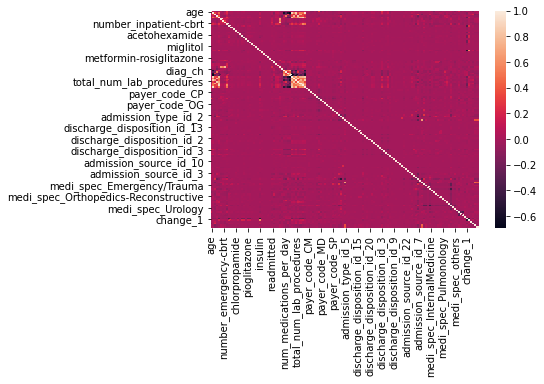

In [0]:
sns.heatmap(db_data_pro.corr())

In [0]:
db_data_pro.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient-cbrt,number_emergency-cbrt,number_inpatient-cbrt,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,readmitted,level1_diag1,level1_diag2,level1_diag3,total_visits-cbrt,diag_ch,num_medications_per_day,num_procedures_per_day,num_lab_procedures_per_day,number_diagnoses_per_day,...,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_2,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,medi_spec_Emergency/Trauma,medi_spec_Family/GeneralPractice,medi_spec_Gastroenterology,medi_spec_InternalMedicine,medi_spec_Nephrology,medi_spec_ObstetricsandGynecology,medi_spec_Orthopedics,medi_spec_Orthopedics-Reconstructive,medi_spec_Psychiatry,medi_spec_Pulmonology,medi_spec_Radiologist,medi_spec_Surgery-Cardiovascular/Thoracic,medi_spec_Surgery-General,medi_spec_Unknown,medi_spec_Urology,medi_spec_others,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_1,change_1,diabetesMed_1,A1Cresult_0,A1Cresult_1,max_glu_serum_0,max_glu_serum_1
0,0.000000,0.000000,0.305344,0.000000,0.0000,0.793701,0.793701,0.793701,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.8,0.0,0.0,0.793701,1.0,0.023810,0.000000,0.445652,0.0625,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
1,0.111111,0.153846,0.442748,0.000000,0.2125,1.144714,0.793701,0.793701,0.533333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,3.0,3.0,3.0,1.144714,0.0,0.142857,0.000000,0.206522,0.1875,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
2,0.222222,0.076923,0.076336,0.833333,0.1500,1.357209,0.793701,1.144714,0.333333,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.0,0.0,0.0,1.518294,1.0,0.142857,0.333333,0.054348,0.1875,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0
3,0.333333,0.076923,0.328244,0.166667,0.1875,0.793701,0.793701,0.793701,0.400000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.0,3.4,7.0,0.793701,3.0,0.190476,0.000000,0.239130,0.1875,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0
4,0.444444,0.000000,0.381679,0.000000,0.0875,0.793701,0.793701,0.793701,0.266667,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2.0,2.0,0.0,0.793701,1.0,0.190476,0.000000,0.554348,0.3125,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0


## **MULTICLASS CLASSIFICATION**

### **Used one model for unbalanced data**

In [0]:
# Trying one model on this unbalanced data
X = db_data_pro.loc[:, db_data_pro.columns!='readmitted']
y = db_data_pro['readmitted']
y = y.values.ravel()


In [0]:
X.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient-cbrt,number_emergency-cbrt,number_inpatient-cbrt,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,level1_diag1,level1_diag2,level1_diag3,total_visits-cbrt,diag_ch,num_medications_per_day,num_procedures_per_day,num_lab_procedures_per_day,number_diagnoses_per_day,total_num_medications-cbrt,...,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_2,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,medi_spec_Emergency/Trauma,medi_spec_Family/GeneralPractice,medi_spec_Gastroenterology,medi_spec_InternalMedicine,medi_spec_Nephrology,medi_spec_ObstetricsandGynecology,medi_spec_Orthopedics,medi_spec_Orthopedics-Reconstructive,medi_spec_Psychiatry,medi_spec_Pulmonology,medi_spec_Radiologist,medi_spec_Surgery-Cardiovascular/Thoracic,medi_spec_Surgery-General,medi_spec_Unknown,medi_spec_Urology,medi_spec_others,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_1,change_1,diabetesMed_1,A1Cresult_0,A1Cresult_1,max_glu_serum_0,max_glu_serum_1
0,0.000000,0.000000,0.305344,0.000000,0.0000,0.793701,0.793701,0.793701,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.8,0.0,0.0,0.793701,1.0,0.023810,0.000000,0.445652,0.0625,1.144714,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
1,0.111111,0.153846,0.442748,0.000000,0.2125,1.144714,0.793701,0.793701,0.533333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3.0,3.0,3.0,1.144714,0.0,0.142857,0.000000,0.206522,0.1875,3.791393,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
2,0.222222,0.076923,0.076336,0.833333,0.1500,1.357209,0.793701,1.144714,0.333333,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.0,0.0,0.0,1.518294,1.0,0.142857,0.333333,0.054348,0.1875,2.981366,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0
3,0.333333,0.076923,0.328244,0.166667,0.1875,0.793701,0.793701,0.793701,0.400000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.0,3.4,7.0,0.793701,3.0,0.190476,0.000000,0.239130,0.1875,3.191252,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0
4,0.444444,0.000000,0.381679,0.000000,0.0875,0.793701,0.793701,0.793701,0.266667,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2.0,2.0,0.0,0.793701,1.0,0.190476,0.000000,0.554348,0.3125,2.040828,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0


In [0]:
y

array([0, 2, 0, ..., 0, 0, 0])

In [0]:
# SPlit the data in train test and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18, random_state=42)
print(X_train.shape, X_test.shape,X_val.shape, y_val.shape,y_train.shape, y_test.shape)


(69783, 131) (15018, 131) (15319, 131) (15319,) (69783,) (15018,)


RANDOM FOREST WITH Unbalanced data:
              precision    recall  f1-score   support

           0       0.60      0.83      0.70      8066
           1       0.38      0.01      0.02      1801
           2       0.50      0.38      0.43      5452

    accuracy                           0.57     15319
   macro avg       0.49      0.41      0.38     15319
weighted avg       0.54      0.57      0.52     15319

[[6697    4 1365]
 [1104   17  680]
 [3371   24 2057]]
Accuracy of Model is 0.5725569554148443
Accuracy and RMSE for training data is:
Training score,RMSE of model is: (1.0, 0.0)
Accuracy and RMSE for test data is:
Test score,RMSE of is: (0.5725569554148443, 1.1640097630073925)


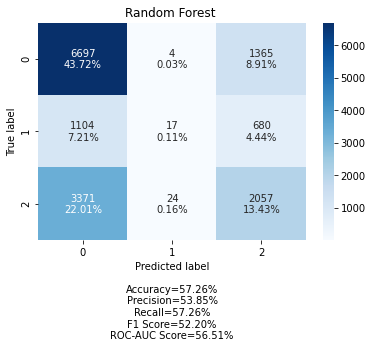

In [0]:
#Random Forest with unbalanced data
print('RANDOM FOREST WITH Unbalanced data:')
re_rfc= RandomForestClassifier(n_estimators=100)
re_rfc.fit(X_train,y_train)
pred_rfc= re_rfc.predict(X_val)

evaluate_model(y_val,pred_rfc)
print(f'Training score,RMSE of model is: {calc_training_RMSE(X_train,y_train,re_rfc)}')
print(f'Test score,RMSE of is: {calc_test_RMSE(X_val, y_val,re_rfc)}')
cnf_rfc= confusion_matrix(y_val,pred_rfc)  
make_confusion_matrix(cnf_rfc,y_val,pred_rfc, title='Random Forest ')


### **Used Undersampling of major class and then oversampling of minority class (Approach -1)**

In [0]:
#oversampling and under sampling

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where
warnings.filterwarnings("ignore")
# define dataset
X = db_data_pro.loc[:, db_data_pro.columns!='readmitted']
X_ou_cols = db_data_pro.loc[:, db_data_pro.columns!='readmitted'].columns.tolist()
y = db_data_pro['readmitted']
# summarize class distribution
counter = Counter(y)
print(counter)
# define pipeline
over_dic  = {1:35545}
under_dic  = {0:35545}
under = RandomUnderSampler(random_state=42, sampling_strategy=under_dic)

over = SMOTE(random_state=42, sampling_strategy=over_dic)

steps = [('u', under),('o', over)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 53218, 2: 35545, 1: 11357})
Counter({0: 35545, 1: 35545, 2: 35545})


In [0]:

X, y = pd.DataFrame(X), pd.DataFrame(y)
for i in range(len(X_ou_cols)):
  X = X.rename(columns={i:X_ou_cols[i]})
y = y.rename(columns={0:'readmitted'})

In [0]:
X.to_csv('/content/drive/My Drive/X_under_over.csv')
y.to_csv('/content/drive/My Drive/y_under_over.csv')

In [0]:
X_sm = pd.read_csv('/content/drive/My Drive/X_under_over.csv') 
y_sm = pd.read_csv('/content/drive/My Drive/y_under_over.csv')

In [0]:
y_sm.head()

,Unnamed: 0,readmitted
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [0]:
X_sm = X_sm.iloc[:,1:]
y_sm = y_sm.iloc[:,1:]
y_sm.values.ravel()

array([0, 0, 0, ..., 1, 1, 1])

Text(0, 0.5, 'Count')

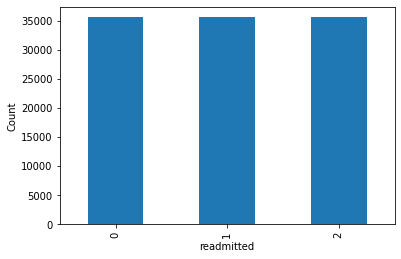

In [0]:
# plot the target feature distribution
y_sm.groupby('readmitted').size().plot(kind='bar')
plt.ylabel('Count')

In [0]:
#TRAIN-TEST-VAL split for under and over sampled data
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18, random_state=42)
print(X_train.shape, X_test.shape,X_val.shape, y_val.shape,y_train.shape, y_test.shape)

(74323, 131) (15996, 131) (16316, 131) (16316, 1) (74323, 1) (15996, 1)


RANDOM FOREST:
              precision    recall  f1-score   support

           0       0.54      0.65      0.59      5351
           1       0.95      0.69      0.80      5573
           2       0.52      0.57      0.54      5392

    accuracy                           0.64     16316
   macro avg       0.67      0.64      0.65     16316
weighted avg       0.68      0.64      0.65     16316

[[3454   60 1837]
 [ 729 3848  996]
 [2180  132 3080]]
Accuracy of Model is 0.6363079186075018
Training score,RMSE of model is: (0.6828572581838731, 0.9782836351868647)
Test score,RMSE of is: (0.6363079186075018, 1.049901056522649)


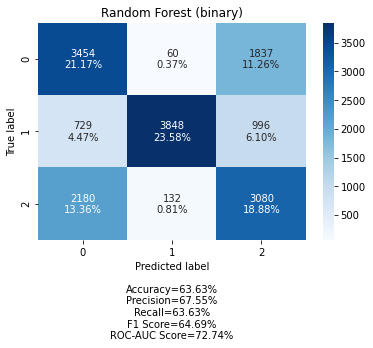

In [0]:
# RandomeForest Classifier for over and under sampled data
print('RANDOM FOREST:')
re_rfc= RandomForestClassifier(n_estimators=500, max_features=7,
                             min_samples_leaf=20)
re_rfc.fit(X_train,y_train)
pred_rfc= re_rfc.predict(X_val)
cnf_rfc= confusion_matrix(y_val,pred_rfc)  
make_confusion_matrix(cnf_rfc,y_val,pred_rfc, title='Random Forest (binary)')
evaluate_model(y_val,pred_rfc)
print(f'Training score,RMSE of model is: {calc_training_RMSE(X_train,y_train,re_rfc)}')
print(f'Test score,RMSE of is: {calc_test_RMSE(X_val, y_val,re_rfc)}')


### **Used Only oversampling technique (SMOTE) to increase the accuracy of the model(Approach-2)**

In [0]:
#oversampling
from collections import Counter
from imblearn.over_sampling import SMOTE
#from matplotlib import pyplot
#from numpy import where
# define dataset
X_sm  = db_data_pro.loc[:, db_data_pro.columns!='readmitted'].values
X_col = db_data_pro.loc[:, db_data_pro.columns!='readmitted'].columns.tolist()
y_sm = db_data_pro['readmitted'].values.ravel()
# summarize class distribution
counter = Counter(y_sm)
print(counter)
# transform the dataset
oversample = SMOTE()
X_sm, y_sm = oversample.fit_resample(X_sm, y_sm)
# summarize the new class distribution
counter = Counter(y_sm)
print(counter)

X_sm, y_sm = pd.DataFrame(X_sm), pd.DataFrame(y_sm)
for i in range(len(X_col)):
  X_sm = X_sm.rename(columns={i:X_col[i]})
y_sm = y_sm.rename(columns={0:'readmitted'})

X_sm.to_csv('X_sm_sampled.csv')
y_sm.to_csv('y_sm_sampled.csv')




Counter({0: 53218, 2: 35545, 1: 11357})
Counter({0: 53218, 2: 53218, 1: 53218})


In [0]:
# Read X and y
X_sm = pd.read_csv('/content/drive/My Drive/X_sm_sampled.csv')
y_sm = pd.read_csv('/content/drive/My Drive/y_sm_sampled.csv')

In [0]:
X_sm  = X_sm.iloc[:,1:]
y_sm = y_sm.iloc[:,1:]
y_sm = y_sm.values.ravel()

### **Tried outlier removal technique to improve the accuracy**

In [0]:
sorted(db_data_pro)
q1, q3 = np.percentile(db_data_pro,[75,100])
iqr = q3 - q1
lower_bound = q1 - iqr
upper_bound = q3 + iqr 


In [0]:

print(iqr, lower_bound, upper_bound)

17.0 -17.0 34.0


In [0]:
from scipy import stats
z_scores = stats.zscore(X_sm)
#calculate z-scores of `df`

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 10).all(axis=1)
new_df = X_sm[filtered_entries]

print(new_df.head())

         age  time_in_hospital  ...  max_glu_serum_0  max_glu_serum_1
2   0.222222          0.076923  ...              0.0              0.0
3   0.333333          0.076923  ...              0.0              0.0
10  0.444444          0.615385  ...              0.0              0.0
16  0.555556          0.230769  ...              0.0              0.0
18  0.777778          0.307692  ...              0.0              0.0

[5 rows x 131 columns]


In [0]:
z_scores = stats.zscore(y_sm)
#calculate z-scores of `df`

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = X_sm[filtered_entries]

print(new_df.head())

In [0]:
y_sm.shape

(159654,)

In [0]:
print(new_df.shape)

(37510, 131)


In [0]:
# TRAIN-TEST-VAL split
X_train, X_test, y_train, y_test = train_test_split(new_df, y_sm[:new_df.shape[0]], test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18, random_state=42)
print(X_train.shape, X_test.shape,X_val.shape, y_val.shape, y_train.shape, y_test.shape)


(26144, 131) (5627, 131) (5739, 131) (5739,) (26144,) (5627,)


In [0]:
#logistic regression 
from sklearn.linear_model import LogisticRegression
re_lr  = LogisticRegression(C = 0.5, solver='liblinear',multi_class='ovr')
re_lr.fit(X_train, y_train)
pred_lr = re_lr.predict(X_val)
evaluate_model(y_val,pred_lr)
print(f'Training score,RMSE of model is: {calc_training_RMSE(X_train, y_train,re_lr )}')
print(f'Test score,RMSE of is: {calc_test_RMSE(X_val, y_val,re_lr )}')
#print(gr_lr.best_params_)
#print(gr_lr.best_estimator_)

              precision    recall  f1-score   support

           0       0.50      0.61      0.55      8305
           1       0.49      0.51      0.50      7959
           2       0.43      0.31      0.36      8163

    accuracy                           0.48     24427
   macro avg       0.47      0.48      0.47     24427
weighted avg       0.47      0.48      0.47     24427

[[5081 1549 1675]
 [2140 4064 1755]
 [2929 2686 2548]]
Accuracy of Model is 0.47869161174110614
Training score,RMSE of model is: (0.47866604360250903, 1.0381609591859438)
Test score,RMSE of is: (0.47869161174110614, 1.0424721916466515)


### **Tried one model on this data to check the accuracy**

In [0]:
# Train-Test-Validation Split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18, random_state=42)
print(X_train.shape, X_test.shape,X_val.shape, y_val.shape, y_train.shape, y_test.shape)

(111278, 131) (23949, 131) (24427, 131) (24427,) (111278,) (23949,)


RANDOM FOREST:
              precision    recall  f1-score   support

           0       0.61      0.77      0.68      8305
           1       0.72      0.77      0.75      7959
           2       0.51      0.34      0.41      8163

    accuracy                           0.63     24427
   macro avg       0.61      0.63      0.61     24427
weighted avg       0.61      0.63      0.61     24427

[[6394   70 1841]
 [1019 6140  800]
 [3078 2297 2788]]
Accuracy of Model is 0.627256724116756
Training score,RMSE of model is: (0.6679217814842107, 0.9295972488826624)
Test score,RMSE of is: (0.627256724116756, 0.988367268339716)


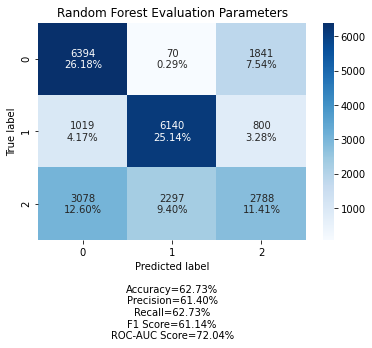

In [0]:
# RandomeForest Classifier
print('RANDOM FOREST:')
re_rfc = RandomForestClassifier(n_estimators=500, max_features=7,
                             min_samples_leaf=20)
re_rfc.fit(X_train,y_train)
pred_rfc = re_rfc.predict(X_val)
evaluate_model(y_val,pred_rfc)
print(f'Training score,RMSE of model is: {calc_training_RMSE(X_train, y_train,re_rfc )}')
print(f'Test score,RMSE of is: {calc_test_RMSE(X_val, y_val,re_rfc )}')
cnf_rfc = confusion_matrix(y_val,pred_rfc)
make_confusion_matrix(cnf_rfc,y_val,pred_rfc,title='Random Forest Evaluation Parameters')

***Here we can see that combination of undersampling and oversampling gave better results compared to only oversampling so we move forward eith approcah 1***

### **Remove payer_code and medical_spec to check whether acuuracy is affected or not**

In [0]:
# Getting payer_code and medical_speciality columns
payer_code_cols = [col for col in X_sm.columns if 'payer' in col]
medical_spec_cols = [col for col in X_sm.columns if 'medi_' in col]

In [0]:
# Dropping these columns and check the accuracy of the model
X_sm.drop(payer_code_cols, axis=1, inplace=True)
X_sm.drop(medical_spec_cols, axis=1, inplace=True)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18, random_state=42)
print(X_train.shape, X_test.shape,X_val.shape, y_val.shape, y_train.shape, y_test.shape)

(74323, 99) (15996, 99) (16316, 99) (16316, 1) (74323, 1) (15996, 1)


RANDOM FOREST:
              precision    recall  f1-score   support

           0       0.54      0.64      0.59      5351
           1       0.96      0.69      0.80      5573
           2       0.52      0.58      0.55      5392

    accuracy                           0.64     16316
   macro avg       0.67      0.63      0.64     16316
weighted avg       0.68      0.64      0.65     16316

[[3430   44 1877]
 [ 721 3822 1030]
 [2182   96 3114]]
Accuracy of Model is 0.6353272860995341
Training score,RMSE of model is: (0.6878086191353955, 0.9698161187700213)
Test score,RMSE of is: (0.6353272860995341, 1.0540376378458158)


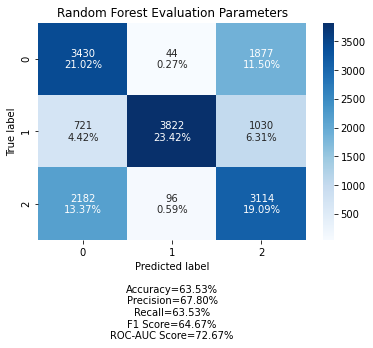

In [0]:
# Random Forest with best params:
print('RANDOM FOREST:')
re_rfc = RandomForestClassifier(n_estimators=500, max_features=7,
                             min_samples_leaf=20)
re_rfc.fit(X_train,y_train)
pred_rfc = re_rfc.predict(X_val)

evaluate_model(y_val,pred_rfc)
print(f'Training score,RMSE of model is: {calc_training_RMSE(X_train, y_train,re_rfc )}')
print(f'Test score,RMSE of is: {calc_test_RMSE(X_val, y_val,re_rfc )}')

cnf_rfc = confusion_matrix(y_val,pred_rfc)
make_confusion_matrix(cnf_rfc,y_val,pred_rfc,title='Random Forest Evaluation Parameters')

**Here we can see that there is no such difference in accuracy after removing payer_code and medical_specialty columns**

### **Checked roc_auc score with 5 folds cross validation to select best models** 

In [0]:
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import  XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [0]:
Name_per = []
Accuracy_per = []
model1=LogisticRegression(random_state=20,C=0.0001,max_iter=400)
model2=GaussianNB()
model3=RandomForestClassifier(n_estimators=250)
model4=GradientBoostingClassifier(n_estimators=250)
model5=KNeighborsClassifier(n_neighbors=5 )
model6=DecisionTreeClassifier(max_depth=11)
model7=LinearDiscriminantAnalysis()
model8 = BaggingClassifier(n_estimators=300)
model9 = XGBClassifier(learning_rate=0.15)
model10 = SGDClassifier()
model11 = SVC(kernel='rbf')
model12 = MLPClassifier()

for model, label in zip([model1, model2, model3, model4,model5,model6,model7,model8,model9,model10,model11,model12], 
                        ['Logistic Regression','Naive Bayes','Random Forest', 'Gradient Boosting','KNN','Decision Tree','LDA','Bagging','XGBoost','SGD','SVC','MLPClassifier']):
    scores_per = cross_val_score(model,X_train,y_train, cv=5, scoring="accuracy")
    Accuracy_per.append(scores_per.mean())
    Name_per.append(model.__class__.__name__)
    print("Accuracy of model %s is %f" % (label,scores_per.mean()))

Accuracy of model Logistic Regression is 0.440168
Accuracy of model Naive Bayes is 0.354724
Accuracy of model Random Forest is 0.661317
Accuracy of model Gradient Boosting is 0.635516
Accuracy of model KNN is 0.581831
Accuracy of model Decision Tree is 0.590494
Accuracy of model LDA is 0.475799
Accuracy of model Bagging is 0.642409
Accuracy of model XGBoost is 0.625874
Accuracy of model SGD is 0.440896
Accuracy of model SVC is 0.482746


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy of model MLPClassifier is 0.592723


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### **Model 1: Random Forest Classifier**

              precision    recall  f1-score   support

           0       0.56      0.61      0.58      5351
           1       0.97      0.71      0.82      5573
           2       0.52      0.61      0.56      5392

    accuracy                           0.65     16316
   macro avg       0.68      0.65      0.66     16316
weighted avg       0.69      0.65      0.66     16316

[[3286   33 2032]
 [ 593 3969 1011]
 [2030   75 3287]]
Accuracy of Model is 0.6461142436871782
Training score,RMSE of model is: (1.0, 0.0)
Test score,RMSE of is: (0.6461142436871782, 1.0491710967204895)


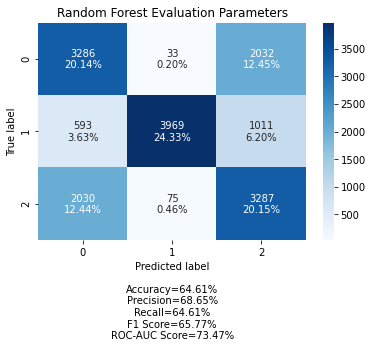

In [0]:
# RandomeForest Classifier 
re_rfc = RandomForestClassifier(n_estimators=200)
re_rfc.fit(X_train,y_train)
pred_rfc = re_rfc.predict(X_val)

evaluate_model(y_val,pred_rfc)
print(f'Training score,RMSE of model is: {calc_training_RMSE(X_train, y_train,re_rfc )}')
print(f'Test score,RMSE of is: {calc_test_RMSE(X_val, y_val,re_rfc )}')

cnf_rfc = confusion_matrix(y_val,pred_rfc)
make_confusion_matrix(cnf_rfc,y_val,pred_rfc,title='Random Forest Evaluation Parameters')

***From the results(Training RMSE and test RMSE), it is clear that model is overfitting the data so we will try hyper-parameter tuning***



In [0]:
# hypertuning the RandomForest Using GridsearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

model1 = RandomForestClassifier(random_state=123)
params = { 'max_features':[5,7,9],'n_estimators': [100, 500, 800],'min_samples_leaf': [5,10,50,100]}
g_search_rf = GridSearchCV(estimator=model1, param_grid=params, cv=5, scoring='accuracy')
g_search_rf.fit(X_train,y_train)
print(g_search_rf.best_params_)
res = g_search_rf.cv_results_
for i,j in zip(res['mean_test_score'], res['params']):
    print(i,j)

{'max_features': 9, 'min_samples_leaf': 5, 'n_estimators': 800}
0.6335663634905588 {'max_features': 5, 'min_samples_leaf': 5, 'n_estimators': 100}
0.6355164523323784 {'max_features': 5, 'min_samples_leaf': 5, 'n_estimators': 500}
0.6358399545429657 {'max_features': 5, 'min_samples_leaf': 5, 'n_estimators': 800}
0.6233936626168709 {'max_features': 5, 'min_samples_leaf': 10, 'n_estimators': 100}
0.6245618909538339 {'max_features': 5, 'min_samples_leaf': 10, 'n_estimators': 500}
0.6244181131357488 {'max_features': 5, 'min_samples_leaf': 10, 'n_estimators': 800}
0.5987796294857608 {'max_features': 5, 'min_samples_leaf': 50, 'n_estimators': 100}
0.5989773402886386 {'max_features': 5, 'min_samples_leaf': 50, 'n_estimators': 500}
0.5991930108517687 {'max_features': 5, 'min_samples_leaf': 50, 'n_estimators': 800}
0.5860367875069391 {'max_features': 5, 'min_samples_leaf': 100, 'n_estimators': 100}
0.5881486062550907 {'max_features': 5, 'min_samples_leaf': 100, 'n_estimators': 500}
0.58804077258

RANDOM FOREST:
              precision    recall  f1-score   support

           0       0.54      0.64      0.59      5351
           1       0.96      0.69      0.80      5573
           2       0.52      0.58      0.55      5392

    accuracy                           0.64     16316
   macro avg       0.67      0.64      0.65     16316
weighted avg       0.68      0.64      0.65     16316

[[3437   51 1863]
 [ 715 3838 1020]
 [2169  104 3119]]
Accuracy of Model is 0.6370433929884776
Training score,RMSE of model is: (0.6890733689436648, 0.9669748171910462)
Test score,RMSE of is: (0.6370433929884776, 1.0508638270656467)


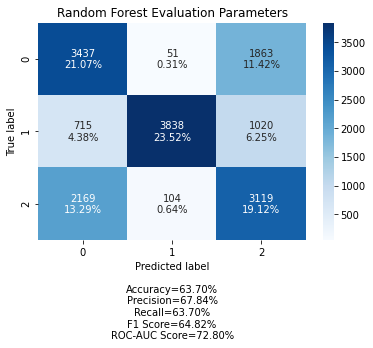

In [0]:
# Random Forest with best params:
print('RANDOM FOREST:')
re_rfc = RandomForestClassifier(n_estimators=800, max_features=7,
                             min_samples_leaf=20)
re_rfc.fit(X_train,y_train)
pred_rfc = re_rfc.predict(X_val)

evaluate_model(y_val,pred_rfc)
print(f'Training score,RMSE of model is: {calc_training_RMSE(X_train, y_train,re_rfc )}')
print(f'Test score,RMSE of is: {calc_test_RMSE(X_val, y_val,re_rfc )}')

cnf_rfc = confusion_matrix(y_val,pred_rfc)
make_confusion_matrix(cnf_rfc,y_val,pred_rfc,title='Random Forest Evaluation Parameters')

Top 15 features are: 
total_visits-cbrt
number_inpatient-cbrt
num_procedures
number_diagnoses
number_outpatient-cbrt
age
number_emergency-cbrt
admission_source_id_7
total_num_procedures
num_medications*num_procedures
time_in_hospital
insulin
num_medications_per_day
gender_1
race_Caucasian


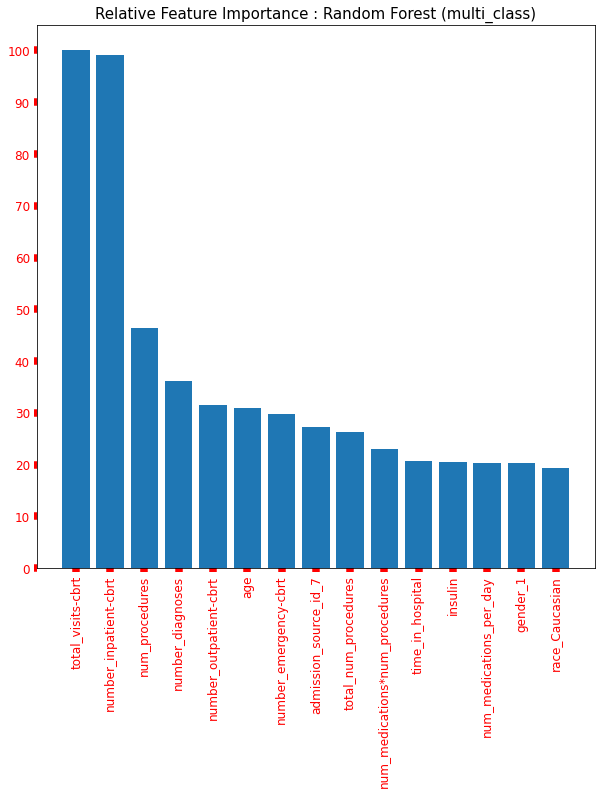

In [0]:
top = feature_importance(re_rfc,X_train,15,title='Random Forest (multi_class)')

### **Tried the model on top features only**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_sm[top], y_sm, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18, random_state=42)
print(X_train.shape, X_test.shape,X_val.shape, y_val.shape, y_train.shape, y_test.shape)

(74323, 15) (15996, 15) (16316, 15) (16316, 1) (74323, 1) (15996, 1)


RANDOM FOREST:
              precision    recall  f1-score   support

           0       0.53      0.65      0.59      5351
           1       0.98      0.67      0.79      5573
           2       0.51      0.56      0.54      5392

    accuracy                           0.63     16316
   macro avg       0.67      0.63      0.64     16316
weighted avg       0.68      0.63      0.64     16316

[[3484   14 1853]
 [ 771 3729 1073]
 [2278   74 3040]]
Accuracy of Model is 0.6284015690120127
Training score,RMSE of model is: (0.6484399176567146, 1.0353466745173874)
Test score,RMSE of is: (0.6284015690120127, 1.063559870407243)


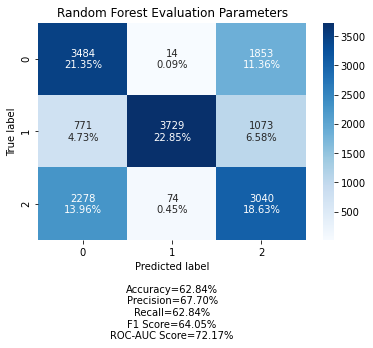

In [0]:
# Random Forest with best params:
print('RANDOM FOREST:')
re_rfc = RandomForestClassifier(n_estimators=800,
                             min_samples_leaf=30)
re_rfc.fit(X_train,y_train)
pred_rfc = re_rfc.predict(X_val)

evaluate_model(y_val,pred_rfc)
print(f'Training score,RMSE of model is: {calc_training_RMSE(X_train, y_train,re_rfc )}')
print(f'Test score,RMSE of is: {calc_test_RMSE(X_val, y_val,re_rfc )}')

cnf_rfc = confusion_matrix(y_val,pred_rfc)
make_confusion_matrix(cnf_rfc,y_val,pred_rfc,title='Random Forest Evaluation Parameters')

### **Tried SelectBest to get best 50 features and then try the model on it**

In [0]:
from sklearn.feature_selection import  SelectKBest
from sklearn.feature_selection import  f_classif, chi2
 
s= SelectKBest(f_classif, k=50)
s.fit(X_sm,y_sm)
X_kbest = s.transform(X_sm)
print(X_kbest.shape)
b = X_sm.columns[s.get_support(indices=True)].tolist()
print(b)
X_kbest = pd.DataFrame(X_kbest)
for i in range(len(b)):
  X_kbest = X_kbest.rename(columns = {i:b[i]})

(106635, 50)
['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient-cbrt', 'number_emergency-cbrt', 'number_inpatient-cbrt', 'number_diagnoses', 'metformin', 'glimepiride', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'level1_diag1', 'level1_diag3', 'total_visits-cbrt', 'num_medications_per_day', 'num_procedures_per_day', 'num_lab_procedures_per_day', 'number_diagnoses_per_day', 'total_num_medications-cbrt', 'total_num_lab_procedures', 'num_medications*num_procedures', 'num_medications*num_lab_procedures', 'num_medications*number_diagnoses', 'total_number_diagnoses', 'admission_type_id_3', 'admission_type_id_5', 'discharge_disposition_id_13', 'discharge_disposition_id_14', 'discharge_disposition_id_15', 'discharge_disposition_id_18', 'discharge_disposition_id_22', 'discharge_disposition_id_28', 'discharge_disposition_id_3', 'discharge_disposition_id_5', 'discharge_disposition_id_6', 'admission_source_id_4', 'admission_sourc

In [0]:
from astropy.table import QTable, Table, Column
from astropy import units as u
import numpy as np

In [0]:
t = Table()
t['feature_names_1'] = best_features_selectkbest[0:25]
t['feature_names_2'] = best_features_selectkbest[25:50]

In [0]:
print(t)

       feature_names_1                  feature_names_2          
------------------------------ ----------------------------------
                           age num_medications*num_lab_procedures
              time_in_hospital   num_medications*number_diagnoses
            num_lab_procedures             total_number_diagnoses
                num_procedures                admission_type_id_3
               num_medications                admission_type_id_5
        number_outpatient-cbrt        discharge_disposition_id_13
         number_emergency-cbrt        discharge_disposition_id_14
         number_inpatient-cbrt        discharge_disposition_id_15
              number_diagnoses        discharge_disposition_id_18
                     metformin        discharge_disposition_id_22
                           ...                                ...
                       insulin              admission_source_id_4
                  level1_diag1              admission_source_id_6
          

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_kbest, y_sm, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18, random_state=42)
print(X_train.shape, X_test.shape,X_val.shape, y_val.shape, y_train.shape, y_test.shape)

(74323, 50) (15996, 50) (16316, 50) (16316, 1) (74323, 1) (15996, 1)


RANDOM FOREST with best features:
              precision    recall  f1-score   support

           0       0.54      0.63      0.59      5351
           1       0.96      0.69      0.80      5573
           2       0.52      0.58      0.55      5392

    accuracy                           0.64     16316
   macro avg       0.67      0.63      0.64     16316
weighted avg       0.68      0.64      0.65     16316

[[3392   50 1909]
 [ 702 3828 1043]
 [2148   97 3147]]
Accuracy of Model is 0.6353885756312821
Training score,RMSE of model is: (0.6828976225394562, 0.974438864545117)
Test score,RMSE of is: (0.6353885756312821, 1.0538341023488238)


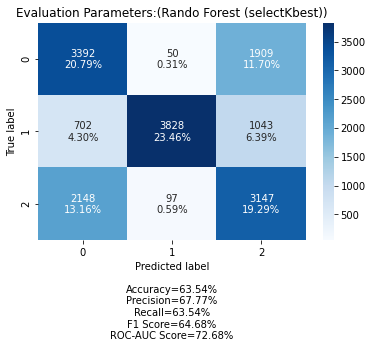

In [0]:
print('RANDOM FOREST with best features:')
re_rfc = RandomForestClassifier(n_estimators=800, max_features=7,
                             min_samples_leaf=30)
re_rfc.fit(X_train,y_train)
pred_rfc = re_rfc.predict(X_val)

evaluate_model(y_val,pred_rfc)
print(f'Training score,RMSE of model is: {calc_training_RMSE(X_train, y_train,re_rfc )}')
print(f'Test score,RMSE of is: {calc_test_RMSE(X_val, y_val,re_rfc )}')

conf_rfc_kbest = confusion_matrix(y_val, pred_rfc)
make_confusion_matrix(conf_rfc_kbest, y_val, pred_rfc, title='Evaluation Parameters:(Random Forest (selectKbest))')

***here we got 63.54% accuracy after selecting features from slectKbest which less than original(63.70%) so we will continue without selecting features***

### **To improve accuracy of the model, implemented feature selection Using Boruta Feature selection algorithm**

In [0]:
pip install boruta

     |████████████████████████████████| 61kB 2.0MB/s 


In [0]:
X_sm.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient-cbrt,number_emergency-cbrt,number_inpatient-cbrt,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,level1_diag1,level1_diag2,level1_diag3,total_visits-cbrt,diag_ch,num_medications_per_day,num_procedures_per_day,num_lab_procedures_per_day,number_diagnoses_per_day,total_num_medications-cbrt,...,discharge_disposition_id_19,discharge_disposition_id_2,discharge_disposition_id_20,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_2,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_1,change_1,diabetesMed_1,A1Cresult_0,A1Cresult_1,max_glu_serum_0,max_glu_serum_1
0,0.555556,0.153846,0.419847,0.166667,0.1750,0.793701,0.793701,0.793701,0.133333,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12.0,3.0,3.0,0.793701,1.0,0.119048,0.0,0.195652,0.0625,3.570018,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.333333,0.307692,0.396947,0.000000,0.1750,1.144714,0.793701,1.518294,0.533333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.1,10.0,16.0,1.650964,3.0,0.071429,0.0,0.108696,0.0625,4.226514,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.555556,0.076923,0.480916,0.000000,0.0875,0.793701,0.793701,0.793701,0.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0,10.0,3.0,0.793701,3.0,0.095238,0.0,0.347826,0.1875,2.545822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.888889,0.153846,0.389313,0.000000,0.0750,0.793701,0.793701,0.793701,0.466667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0,3.0,3.8,0.793701,3.0,0.047619,0.0,0.184783,0.1250,2.780649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.666667,0.153846,0.480916,0.000000,0.3250,1.144714,1.144714,0.793701,0.466667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,12.0,1.357209,1.0,0.214286,0.0,0.228261,0.1250,4.335633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [0]:
#feature selection using boruta algorithm
from boruta import BorutaPy
X= X_sm.values
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
boruta_feature_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=4242, max_iter = 75, perc = 90)
boruta_feature_selector.fit(X, y_sm) 
X_boruta = boruta_feature_selector.transform(X)
X_boruta.shape
X= pd.DataFrame(X)
features = [f for f in X_sm.columns]
final_features = list()
indexes = np.where(boruta_feature_selector.support_ == True)
for x in np.nditer(indexes):
    final_features.append(features[x])
print(final_features)

Iteration: 	1 / 75
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	2 / 75
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	3 / 75
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	4 / 75
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	5 / 75
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	6 / 75
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	7 / 75
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	8 / 75
Confirmed: 	54
Tentative: 	7
Rejected: 	38
Iteration: 	9 / 75
Confirmed: 	54
Tentative: 	7
Rejected: 	38
Iteration: 	10 / 75
Confirmed: 	54
Tentative: 	7
Rejected: 	38
Iteration: 	11 / 75
Confirmed: 	54
Tentative: 	7
Rejected: 	38
Iteration: 	12 / 75
Confirmed: 	54
Tentative: 	7
Rejected: 	38
Iteration: 	13 / 75
Confirmed: 	54
Tentative: 	7
Rejected: 	38
Iteration: 	14 / 75
Confirmed: 	54
Tentative: 	7
Rejected: 	38
Iteration: 	15 / 75
Confirmed: 	54
Tentative: 	6
Rejected: 	39
Iteration: 	16 / 75
Confirmed: 	55
Tentative: 	5
Rejected: 	39
Iteratio

In [0]:
final_features= ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient-cbrt', 'number_emergency-cbrt', 'number_inpatient-cbrt', 'number_diagnoses', 'metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'level1_diag1', 'level1_diag2', 'level1_diag3', 'total_visits-cbrt', 'num_medications_per_day', 'num_procedures_per_day', 'num_lab_procedures_per_day', 'number_diagnoses_per_day', 'total_num_medications-cbrt', 'total_num_procedures', 'total_num_lab_procedures', 'num_medications*num_procedures', 'num_medications*num_lab_procedures', 'num_medications*number_diagnoses', 'total_number_diagnoses', 'admission_type_id_2', 'admission_type_id_3', 'admission_type_id_5', 'discharge_disposition_id_13', 'discharge_disposition_id_14', 'discharge_disposition_id_18', 'discharge_disposition_id_2', 'discharge_disposition_id_22', 'discharge_disposition_id_3', 'discharge_disposition_id_5', 'discharge_disposition_id_6', 'admission_source_id_4', 'admission_source_id_6', 'admission_source_id_7', 'admission_source_id_9', 'race_Caucasian', 'race_Other', 'gender_1', 'change_1', 'diabetesMed_1', 'A1Cresult_0', 'A1Cresult_1', 'max_glu_serum_0', 'max_glu_serum_1']

In [0]:
final_features= ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient-cbrt', 'number_emergency-cbrt', 'number_inpatient-cbrt', 'number_diagnoses', 'metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'level1_diag1', 'level1_diag2', 'level1_diag3', 'total_visits-cbrt', 'num_medications_per_day', 'num_procedures_per_day', 'num_lab_procedures_per_day', 'number_diagnoses_per_day', 'total_num_medications-cbrt', 'total_num_procedures', 'total_num_lab_procedures', 'num_medications*num_procedures', 'num_medications*num_lab_procedures', 'num_medications*number_diagnoses', 'total_number_diagnoses', 'admission_type_id_2', 'admission_type_id_3', 'admission_type_id_5', 'discharge_disposition_id_13', 'discharge_disposition_id_14', 'discharge_disposition_id_18', 'discharge_disposition_id_2', 'discharge_disposition_id_22', 'discharge_disposition_id_3', 'discharge_disposition_id_5', 'discharge_disposition_id_6', 'admission_source_id_4', 'admission_source_id_6', 'admission_source_id_7', 'admission_source_id_9', 'race_Caucasian', 'race_Other', 'gender_1', 'change_1', 'diabetesMed_1', 'A1Cresult_0', 'A1Cresult_1', 'max_glu_serum_0', 'max_glu_serum_1']

In [0]:
t = Table()
t['feature_names_1_boruta'] = final_features[0:28]
t['feature_names_2_boruta'] = final_features[28:56]

In [0]:
# import sys
print(t)

    feature_names_1_boruta           feature_names_2_boruta      
------------------------------ ----------------------------------
                           age num_medications*num_lab_procedures
              time_in_hospital   num_medications*number_diagnoses
            num_lab_procedures             total_number_diagnoses
                num_procedures                admission_type_id_2
               num_medications                admission_type_id_3
        number_outpatient-cbrt                admission_type_id_5
         number_emergency-cbrt        discharge_disposition_id_13
         number_inpatient-cbrt        discharge_disposition_id_14
              number_diagnoses        discharge_disposition_id_18
                     metformin         discharge_disposition_id_2
                           ...                                ...
                  level1_diag2              admission_source_id_9
                  level1_diag3                     race_Caucasian
          

In [0]:
# Train-test-validation split for boruta features
X_train, X_test,y_train, y_test = train_test_split(X_sm[final_features], y_sm, test_size=0.15, random_state=42)
X_train, X_val,y_train, y_val = train_test_split(X_train,y_train, test_size=0.18, random_state=42)
print(X_train.shape, X_test.shape,X_val.shape, y_val.shape,y_train.shape, y_test.shape)

(74323, 55) (15996, 55) (16316, 55) (16316, 1) (74323, 1) (15996, 1)


(74323, 55) (15996, 55) (16316, 55) (16316, 1) (74323, 1) (15996, 1)
RANDOM FOREST:
              precision    recall  f1-score   support

           0       0.55      0.63      0.59      5351
           1       0.97      0.69      0.81      5573
           2       0.52      0.59      0.55      5392

    accuracy                           0.64     16316
   macro avg       0.68      0.64      0.65     16316
weighted avg       0.68      0.64      0.65     16316

[[3367   41 1943]
 [ 670 3853 1050]
 [2120   73 3199]]
Accuracy of Model is 0.638575631282177
Training score,RMSE of model is: (0.7115294054330422, 0.9237145976356425)
Test score,RMSE of is: (0.638575631282177, 1.0528449416670624)


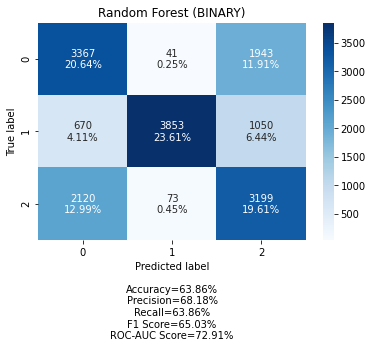

In [0]:
# TRAIN-TEST-VAL split (Using features of Boruta Algorithm)
X_train, X_test,y_train, y_test = train_test_split(X_sm[final_features], y_sm, test_size=0.15, random_state=42)
X_train, X_val,y_train, y_val = train_test_split(X_train,y_train, test_size=0.18, random_state=42)
print(X_train.shape, X_test.shape,X_val.shape, y_val.shape,y_train.shape, y_test.shape)

# Random Forest with best params:
print('RANDOM FOREST:')
re_rfc= RandomForestClassifier(n_estimators=800,max_features=7,
                             min_samples_leaf=20)
re_rfc.fit(X_train,y_train)
pred_rfc= re_rfc.predict(X_val)
evaluate_model(y_val,pred_rfc)
print(f'Training score,RMSE of model is: {calc_training_RMSE(X_train,y_train,re_rfc)}')
print(f'Test score,RMSE of is: {calc_test_RMSE(X_val, y_val,re_rfc)}')

conf_rfc= confusion_matrix(y_val, pred_rfc)


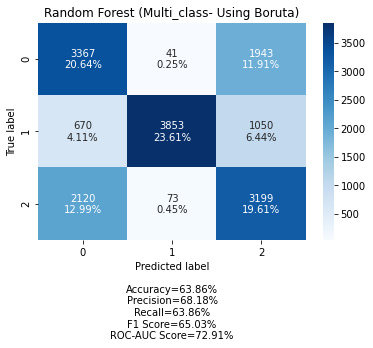

In [0]:
make_confusion_matrix(conf_rfc,y_val,pred_rfc,title='Random Forest (Multi_class- Using Boruta)')

Top 15 features are: 
number_inpatient-cbrt
total_visits-cbrt
num_procedures
number_diagnoses
number_outpatient-cbrt
age
number_emergency-cbrt
admission_source_id_7
total_num_procedures
num_medications*num_procedures
time_in_hospital
insulin
num_medications*number_diagnoses
num_medications*num_lab_procedures
total_number_diagnoses


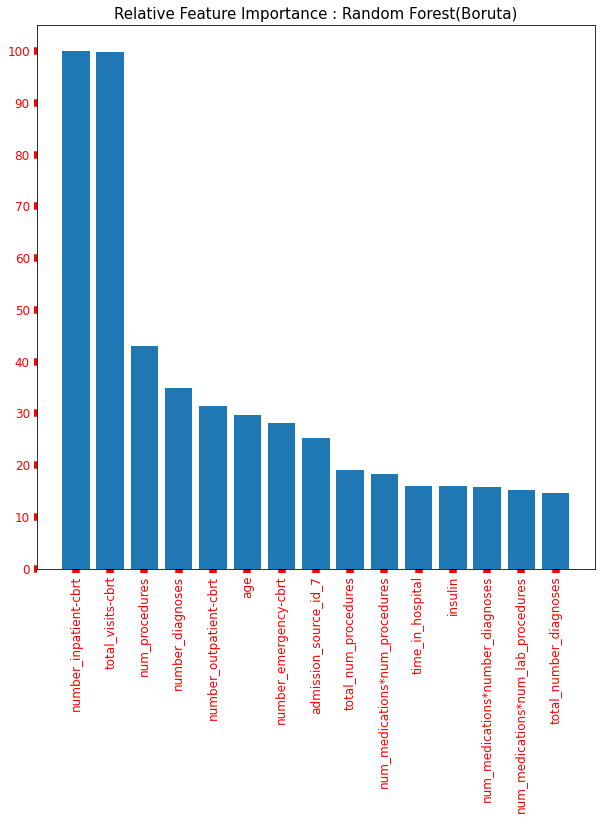

['number_inpatient-cbrt',
 'total_visits-cbrt',
 'num_procedures',
 'number_diagnoses',
 'number_outpatient-cbrt',
 'age',
 'number_emergency-cbrt',
 'admission_source_id_7',
 'total_num_procedures',
 'num_medications*num_procedures',
 'time_in_hospital',
 'insulin',
 'num_medications*number_diagnoses',
 'num_medications*num_lab_procedures',
 'total_number_diagnoses']

In [0]:
feature_importance(re_rfc,X_train,15, title='Random Forest(Boruta)')

***Here accuracy is improved from 63.7% to 63.85% so we will continue with boruta algorithm***

In [0]:
# Random forest on test data
pred_rfc = re_rfc.predict(X_test)

evaluate_model(y_test,pred_rfc)
print(f'Training score,RMSE of model is: {calc_training_RMSE(X_train, y_train,re_rfc )}')
print(f'Test score,RMSE of is: {calc_test_RMSE(X_test, y_test,re_rfc )}')

conf_rfc_test = confusion_matrix(y_test, pred_rfc)
make_confusion_matrix(conf_rfc_test, y_test, pred_rfc, title='Evaluation Parameters:Random Forest(Boruta)-test data')

### **Model 2: Support Vector Machine**

In [0]:
# Support vector machine Classifier SVC
print('Support Vector Classifier:')
re_svc= SVC()
re_svc.fit(X_train,y_train)
pred_svc= re_svc.predict(X_val)
evaluate_model(y_val,pred_svc)
print(f'Training RMSE of model is: {calc_training_RMSE(X_train,y_train,re_svc)}')
print(f'Test RMSE of is: {calc_test_RMSE(X_val, y_val,re_svc)}')
conf_svc= confusion_matrix(y_val,pred_svc)
make_confusion_matrix(conf_svc,y_val,pred_svc)

In [0]:
# Code for hyperparameter tuning using GridsearchCV
# We tried this on another machine as this model was taking too much time
# After hypertuning we got the followung parameters:
# {'kernel' : 'rbf', 'gamma' : 0.15, 'C' : 10000}

              precision    recall  f1-score   support

           0       0.51      0.51      0.51      5351
           1       0.78      0.86      0.82      5573
           2       0.50      0.44      0.47      5392

    accuracy                           0.61     16316
   macro avg       0.60      0.60      0.60     16316
weighted avg       0.60      0.61      0.60     16316

[[2752  600 1999]
 [ 392 4810  371]
 [2266  769 2357]]
Accuracy of Model is 0.6079308654081883
Training RMSE of model is: (0.9999192712888338, 0.016809238206457834)
Test RMSE of is: (0.6079308654081883, 1.0845592161367599)


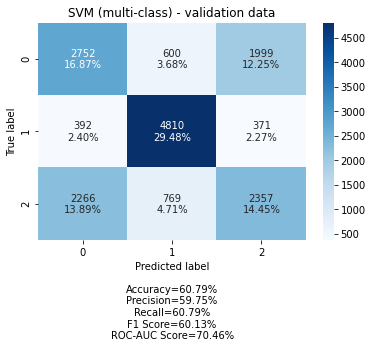

In [0]:
# Support vector machine Classifier SVC
print('Support Vector Classifier:')
re_svc= SVC(kernel='rbf', gamma=0.15, C=10000)
re_svc.fit(X_train, y_train)
pred_svc= re_svc.predict(X_val)
evaluate_model(y_val,pred_svc)
print(f'Training RMSE of model is: {calc_training_RMSE(X_train,y_train,re_svc)}')
print(f'Test RMSE of is: {calc_test_RMSE(X_val, y_val,re_svc)}')
conf_svc= confusion_matrix(y_val,pred_svc)
make_confusion_matrix(conf_svc,y_val,pred_svc, title= 'SVM (multi-class) - validation data')
  

In [0]:

# Save to file in the current working directory
with open("/content/drive/My Drive/model_svm.pkl", 'wb') as file:
    pickle.dump(re_svc, file)

              precision    recall  f1-score   support

           0       0.52      0.54      0.53      5310
           1       0.77      0.85      0.81      5319
           2       0.51      0.44      0.47      5367

    accuracy                           0.61     15996
   macro avg       0.60      0.61      0.60     15996
weighted avg       0.60      0.61      0.60     15996

[[2857  553 1900]
 [ 397 4514  408]
 [2241  761 2365]]
Accuracy of Model is 0.6086521630407602
Training RMSE of model is: (0.9999192712888338, 0.016809238206457834)
Test RMSE of is: (0.6086521630407602, 1.080731000237209)


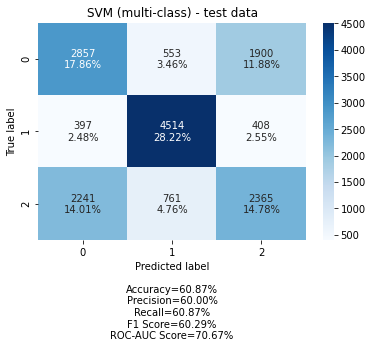

In [0]:
pred_svc= re_svc.predict(X_test)
evaluate_model(y_test,pred_svc)
print(f'Training RMSE of model is: {calc_training_RMSE(X_train,y_train,re_svc)}')
print(f'Test RMSE of is: {calc_test_RMSE(X_test, y_test,re_svc)}')
conf_svc= confusion_matrix(y_test,pred_svc)
make_confusion_matrix(conf_svc,y_test,pred_svc, title= 'SVM (multi-class) - test data')

### **Model 3: XGBoost Classifier**

XGBoost classifier:
              precision    recall  f1-score   support

           0       0.56      0.62      0.59      5351
           1       0.98      0.70      0.82      5573
           2       0.52      0.62      0.57      5392

    accuracy                           0.65     16316
   macro avg       0.69      0.65      0.66     16316
weighted avg       0.69      0.65      0.66     16316

[[3316   19 2016]
 [ 594 3927 1052]
 [1988   61 3343]]
Accuracy of Model is 0.6488109830840892
Training RMSE of model is: (0.6868264198162076, 0.9784624138358508)
Test RMSE of is: (0.6488109830840892, 1.0427841925694001)


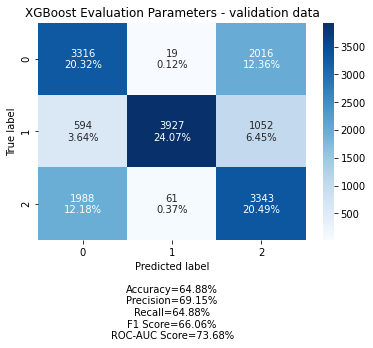

In [0]:
# XGboost
print('XGBoost classifier:')
from xgboost import XGBClassifier
re_xgb = XGBClassifier(
                      learning_rate=0.01,  
                      n_estimators=1000,
                      max_depth=7, 
                      gamma=0.2)
re_xgb.fit(X_train,y_train)
pred_xgb = re_xgb.predict(X_val)

evaluate_model(y_val,pred_xgb)
print(f'Training RMSE of model is: {calc_training_RMSE(X_train, y_train,re_xgb )}')
print(f'Test RMSE of is: {calc_test_RMSE(X_val, y_val,re_xgb )}')

cnf_xgb = confusion_matrix(y_val, pred_xgb)
make_confusion_matrix(cnf_xgb,y_val,pred_xgb,title='XGBoost Evaluation Parameters - validation data')

Top 15 features are: 
number_inpatient-cbrt
discharge_disposition_id_3
num_procedures
insulin
total_visits-cbrt
age
discharge_disposition_id_22
race_Caucasian
gender_1
number_diagnoses
metformin
discharge_disposition_id_6
time_in_hospital
num_procedures_per_day
admission_source_id_7


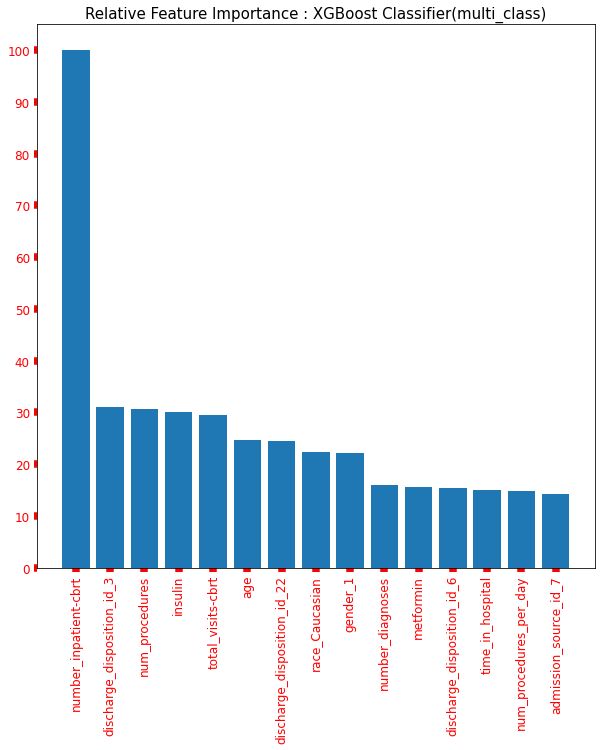

In [0]:
top = feature_importance(re_xgb,X_train,15,title='XGBoost Classifier(multi_class)')

              precision    recall  f1-score   support

           0       0.57      0.63      0.60      5310
           1       0.97      0.67      0.80      5319
           2       0.53      0.63      0.58      5367

    accuracy                           0.65     15996
   macro avg       0.69      0.65      0.66     15996
weighted avg       0.69      0.65      0.66     15996

[[3368   31 1911]
 [ 625 3581 1113]
 [1897   65 3405]]
Accuracy of Model is 0.6472868217054264
Training RMSE of model is: (0.6868264198162076, 0.9784624138358508)
Test RMSE of is: (0.6472868217054264, 1.0329045081374815)


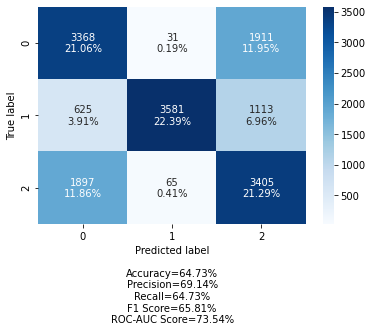

In [0]:
pred_xgb= re_xgb.predict(X_test)
evaluate_model(y_test,pred_xgb)
print(f'Training RMSE of model is: {calc_training_RMSE(X_train, y_train,re_xgb)}')
print(f'Test RMSE of is: {calc_test_RMSE(X_test, y_test,re_xgb)}')
conf_xgb_test = confusion_matrix(y_test, pred_xgb)
make_confusion_matrix(conf_xgb_test,y_test,pred_xgb)

### **Model 4: KNN**

KNN :
              precision    recall  f1-score   support

           0       0.49      0.39      0.44      5351
           1       0.49      0.83      0.62      5573
           2       0.47      0.23      0.31      5392

    accuracy                           0.49     16316
   macro avg       0.49      0.48      0.46     16316
weighted avg       0.49      0.49      0.46     16316

[[2098 2209 1044]
 [ 596 4618  359]
 [1593 2537 1262]]
Accuracy of Model is 0.4889678842853641
Training RMSE of model is: (0.5886872166085868, 0.8978624113442641)
Test RMSE of is: (0.4889678842853641, 0.9979446885338312)


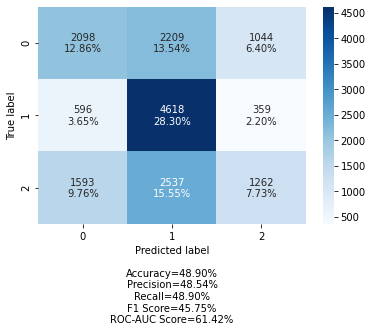

In [0]:
# KNN
print('KNN :')
from sklearn.neighbors import KNeighborsClassifier
re_knn= KNeighborsClassifier(n_neighbors=10)
re_knn.fit(X_train,y_train)
pred_knn= re_knn.predict(X_val)
evaluate_model(y_val,pred_knn)
print(f'Training RMSE of model is: {calc_training_RMSE(X_train, y_train,re_knn)}')
print(f'Test RMSE of is: {calc_test_RMSE(X_val, y_val,re_knn)}')
conf_knn = confusion_matrix(y_val, pred_knn)
make_confusion_matrix(conf_knn,y_val,pred_knn)

In [0]:
# KNN Hyperparameter Tuning
grid_params = {
  'n_neighbors' : [3,5,11,19,25],
  'weights' : ['uniform', 'distance'],
  'metric' : ['euclidean', 'manhattan']
  }

gs_knn = GridSearchCV(KNeighborsClassifier(), grid_params, verbose=1, cv=3, n_jobs=-1)
gs_knn_results =  gs_knn.fit(X_train, y_train)
print(gs_knn_results.best_estimator_)
print(gs_knn_results.best_score_)
print(gs_knn_results.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 11.9min finished


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='distance')
0.5753535502143549
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


KNN :
              precision    recall  f1-score   support

           0       0.53      0.50      0.52      5351
           1       0.66      0.84      0.74      5573
           2       0.51      0.39      0.45      5392

    accuracy                           0.58     16316
   macro avg       0.57      0.58      0.57     16316
weighted avg       0.57      0.58      0.57     16316

[[2685 1069 1597]
 [ 473 4692  408]
 [1913 1361 2118]]
Accuracy of Model is 0.5819441039470459
Training RMSE of model is: (1.0, 0.0)
Test RMSE of is: (0.5819441039470459, 1.0312296860346664)


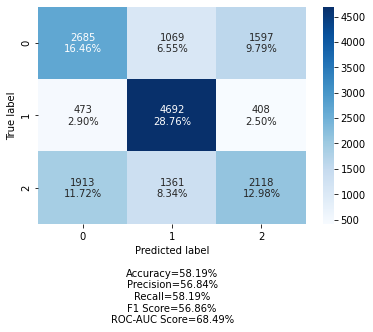

In [0]:
#KNN with best params
print('KNN :')
from sklearn.neighbors import KNeighborsClassifier
re_knn= KNeighborsClassifier(n_neighbors=3, weights='distance', metric='manhattan')
re_knn.fit(X_train,y_train)
pred_knn= re_knn.predict(X_val)
evaluate_model(y_val,pred_knn)
print(f'Training RMSE of model is: {calc_training_RMSE(X_train, y_train,re_knn)}')
print(f'Test RMSE of is: {calc_test_RMSE(X_val, y_val,re_knn)}')
conf_knn = confusion_matrix(y_val, pred_knn)
make_confusion_matrix(conf_knn,y_val,pred_knn)

In [0]:
import pickle

#
# Create your model here (same as above)
#

# Save to file in the current working directory
with open("/content/drive/My Drive/model_knn.pkl", 'wb') as file:
    pickle.dump(re_knn, file)

# Load from file
with open("/content/drive/My Drive/model_knn.pkl", 'rb') as file:
    pickle_model = pickle.load(file)
    

Ypredict = pickle_model.predict(X_test)

In [0]:
pred_knn= re_knn.predict(X_test)
evaluate_model(y_test,pred_knn)
print(f'Training RMSE of model is: {calc_training_RMSE(X_train, y_train,re_knn)}')
print(f'Test RMSE of is: {calc_test_RMSE(X_test, y_test,re_knn)}')
conf_knn_test = confusion_matrix(y_test, pred_knn)
make_confusion_matrix(conf_knn_test,y_test,pred_knn, title='KNN (multi-class) - Test data')

KeyboardInterrupt: ignored

### **Model 5: Decision Tree Classifier**

Decision Tree classifier:
              precision    recall  f1-score   support

           0       0.48      0.48      0.48      5351
           1       0.72      0.73      0.73      5573
           2       0.46      0.46      0.46      5392

    accuracy                           0.56     16316
   macro avg       0.56      0.56      0.56     16316
weighted avg       0.56      0.56      0.56     16316

[[2568  730 2053]
 [ 675 4074  824]
 [2060  848 2484]]
Accuracy of Model is 0.5593282667320422
Training RMSE of model is: (1.0, 0.0)
Test RMSE of is: (0.5593282667320422, 1.0940398829595983)


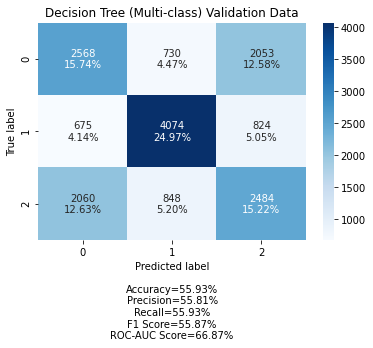

In [0]:
#decision tree classifier
from sklearn.tree import DecisionTreeClassifier
print('Decision Tree classifier:')
re_dec = DecisionTreeClassifier()
re_dec.fit(X_train,y_train)
pred_dec = re_dec.predict(X_val)
evaluate_model(y_val,pred_dec)
print(f'Training RMSE of model is: {calc_training_RMSE(X_train, y_train,re_dec )}')
print(f'Test RMSE of is: {calc_test_RMSE(X_val, y_val,re_dec )}')
conf_dec = confusion_matrix(y_val, pred_dec)
make_confusion_matrix(conf_dec,y_val,pred_dec, title='Decision Tree (Multi-class) Validation Data')

In [0]:
#hypertuning Decision tree classifier
grid_params_dec = {
  'max_depth' : [3,5,11,19,25],
  'criterion' : ['gini', 'entropy'],
  'min_samples_leaf' : [1,3,5,7,9,11]
  }

gs_knn = GridSearchCV(DecisionTreeClassifier(), grid_params_dec, verbose=1, cv=3, n_jobs=-1)
gs_knn_results =  gs_knn.fit(X_train, y_train)
print(gs_knn_results.best_estimator_)
print(gs_knn_results.best_score_)
print(gs_knn_results.best_params_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   56.7s finished


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=11, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
0.5990608819164195
{'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 5}


Decision Tree classifier:
              precision    recall  f1-score   support

           0       0.51      0.67      0.58      5351
           1       0.95      0.62      0.75      5573
           2       0.50      0.52      0.51      5392

    accuracy                           0.60     16316
   macro avg       0.65      0.60      0.61     16316
weighted avg       0.66      0.60      0.61     16316

[[3586   58 1707]
 [1014 3441 1118]
 [2457  112 2823]]
Accuracy of Model is 0.6037018877175778
Training RMSE of model is: (0.6169153559463423, 1.0614503297869602)
Test RMSE of is: (0.6037018877175778, 1.0779271510070412)


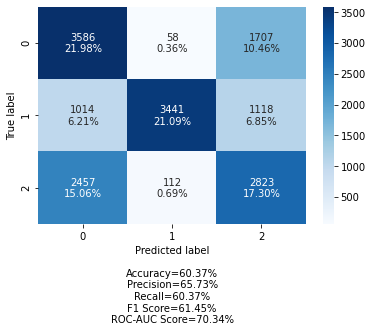

In [0]:
# Decision tree classifier with best params
from sklearn.tree import DecisionTreeClassifier
print('Decision Tree classifier:')
re_dec = DecisionTreeClassifier(criterion='gini', max_depth=11, 
                                min_samples_leaf=5)
re_dec.fit(X_train,y_train)
pred_dec = re_dec.predict(X_val)
evaluate_model(y_val,pred_dec)
print(f'Training RMSE of model is: {calc_training_RMSE(X_train, y_train,re_dec )}')
print(f'Test RMSE of is: {calc_test_RMSE(X_val, y_val,re_dec )}')
conf_dec = confusion_matrix(y_val, pred_dec)
make_confusion_matrix(conf_dec,y_val,pred_dec)

In [0]:
# Save to file in the current working directory
with open("/content/drive/My Drive/model_dec.pkl", 'wb') as file:
    pickle.dump(re_dec, file)

In [0]:
# Load from file
import pickle
with open("/content/drive/My Drive/model_dec.pkl", 'rb') as file:
    model_dec = pickle.load(file)

In [0]:
y_sm.astype(str)

,readmitted
0,0
1,0
2,0
3,0
4,0
...,...
106630,1
106631,1
106632,1
106633,1


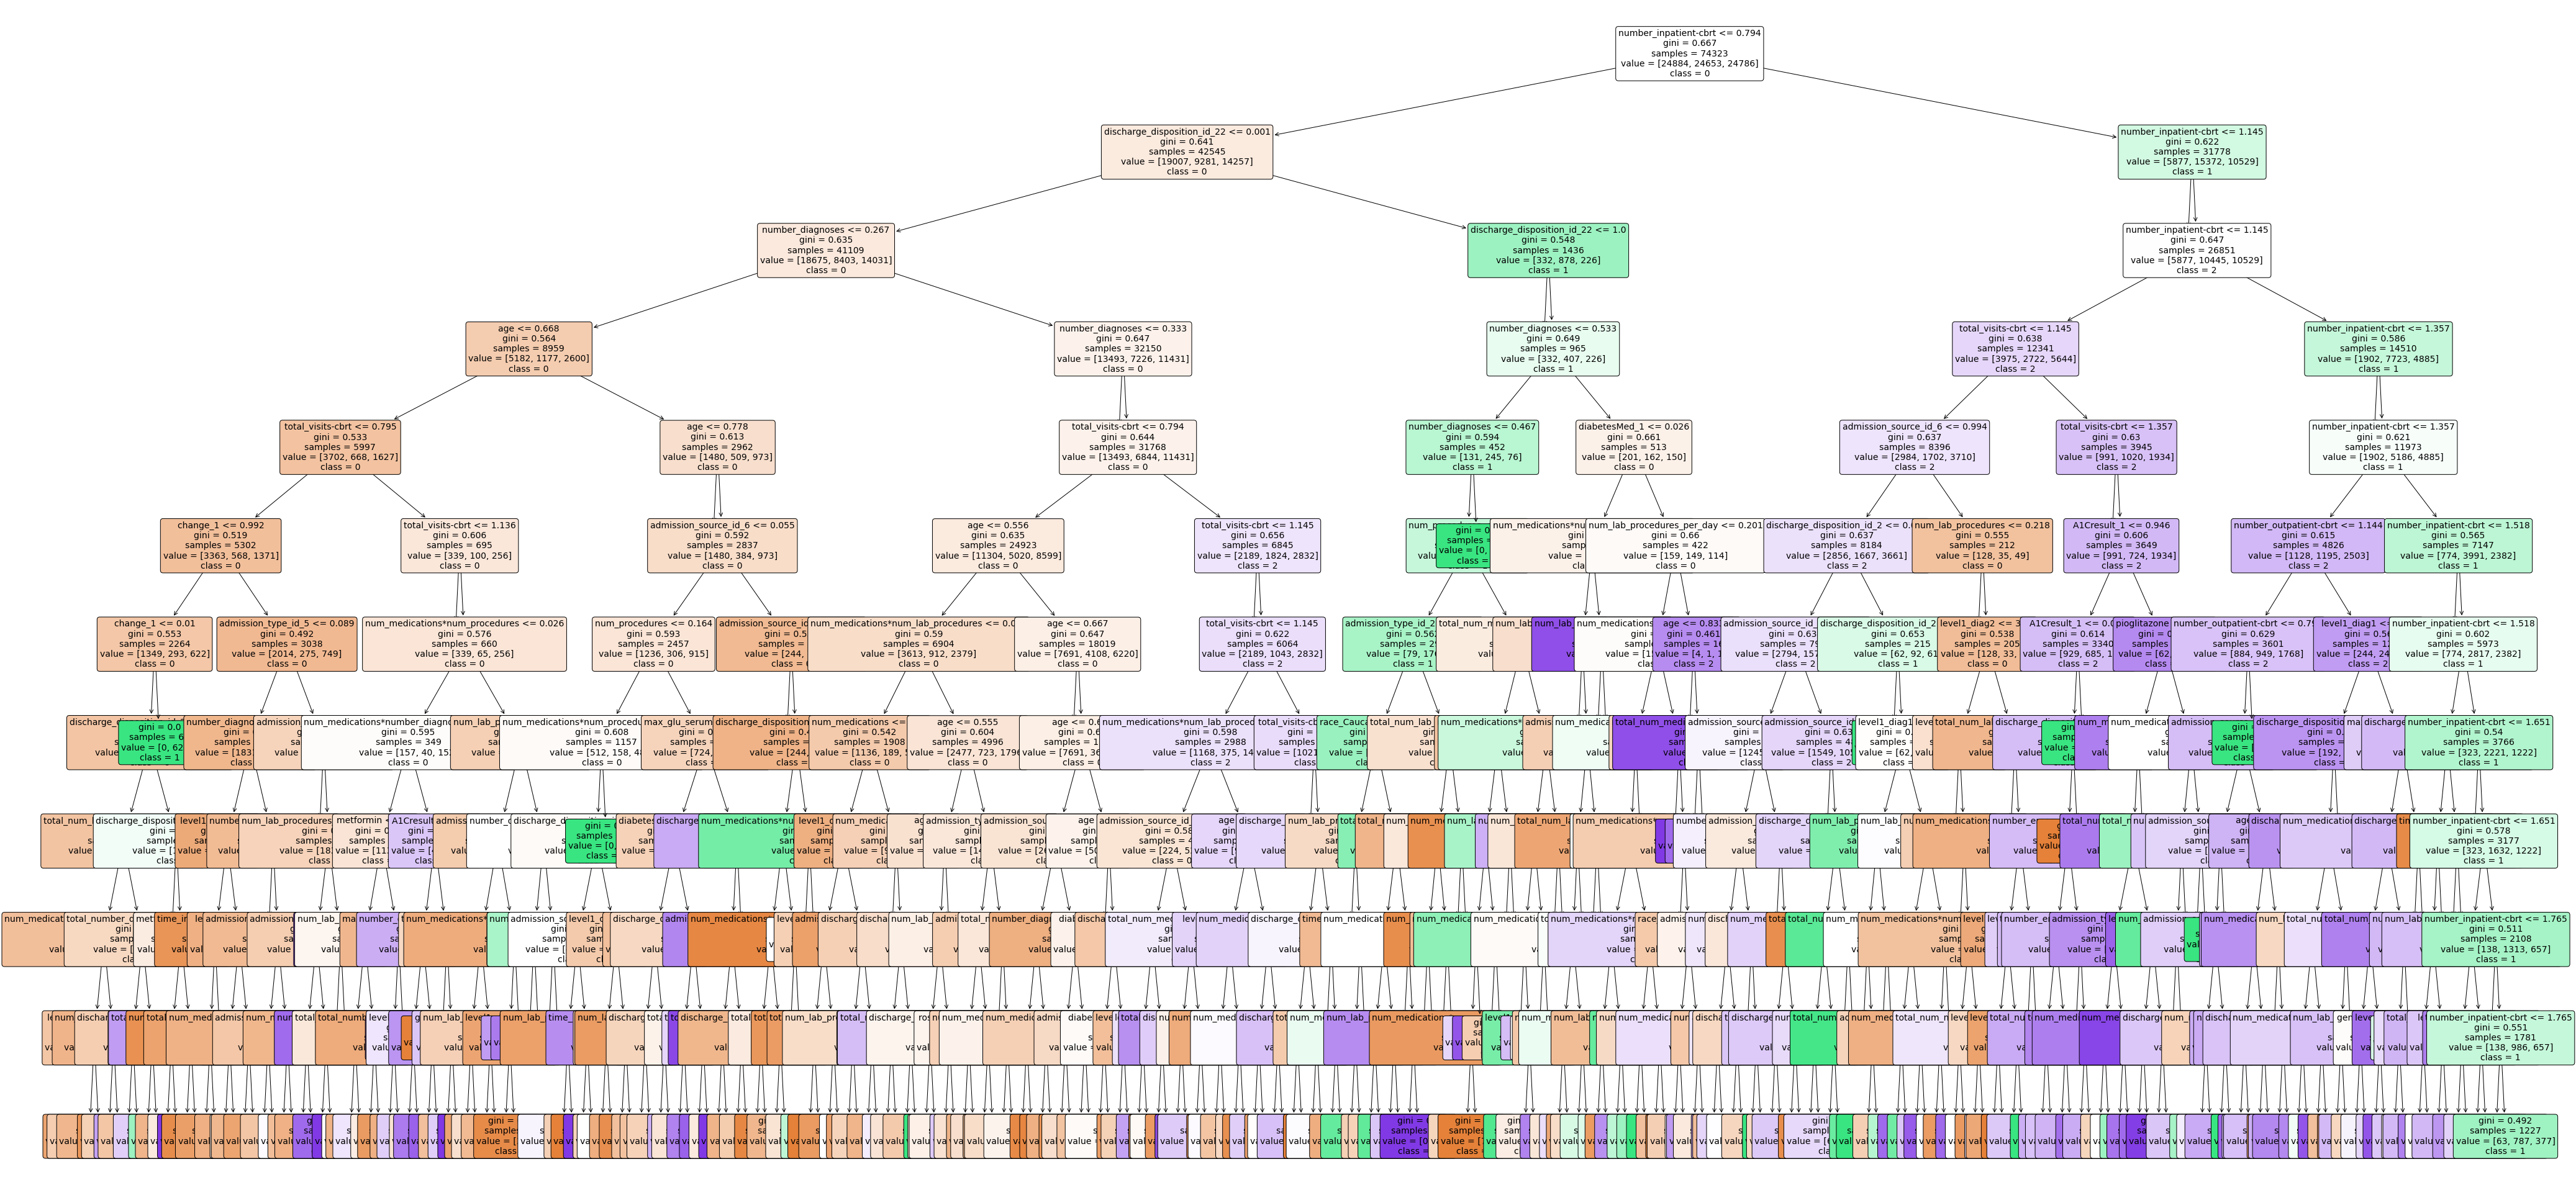

In [0]:
from sklearn.tree import plot_tree
plt.figure(figsize=(70,35))
a = plot_tree(model_dec, 
              feature_names=final_features, 
              class_names=['0','1','2'], 
              filled=True, 
              rounded=True, 
              fontsize=14)

              precision    recall  f1-score   support

           0       0.51      0.68      0.58      5310
           1       0.95      0.60      0.73      5319
           2       0.50      0.53      0.52      5367

    accuracy                           0.60     15996
   macro avg       0.65      0.60      0.61     15996
weighted avg       0.65      0.60      0.61     15996

[[3594   49 1667]
 [1000 3167 1152]
 [2400  128 2839]]
Accuracy of Model is 0.6001500375093773
Training RMSE of model is: (0.6169153559463423, 1.0614503297869602)
Test RMSE of is: (0.6001500375093773, 1.0782407666136988)


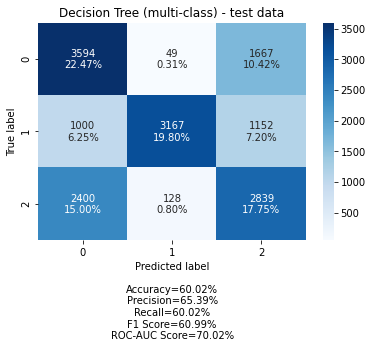

In [0]:
pred_dec = model_dec.predict(X_test)
evaluate_model(y_test,pred_dec)
print(f'Training RMSE of model is: {calc_training_RMSE(X_train, y_train,model_dec )}')
print(f'Test RMSE of is: {calc_test_RMSE(X_test, y_test,model_dec )}')
conf_dec = confusion_matrix(y_test, pred_dec)
make_confusion_matrix(conf_dec,y_test,pred_dec, title='Decision Tree (multi-class) - test data')

### **Model 6: MLPClassifier**

MLPClassifier
              precision    recall  f1-score   support

           0       0.56      0.54      0.55      5351
           1       0.76      0.68      0.72      5573
           2       0.49      0.56      0.52      5392

    accuracy                           0.60     16316
   macro avg       0.60      0.59      0.60     16316
weighted avg       0.61      0.60      0.60     16316

[[2909  499 1943]
 [ 629 3794 1150]
 [1700  686 3006]]
Accuracy of Model is 0.595060063741113
Training RMSE of model is: (0.6253111419076195, 1.0164808504984515)
Test RMSE of is: (0.595060063741113, 1.0367127030824559)


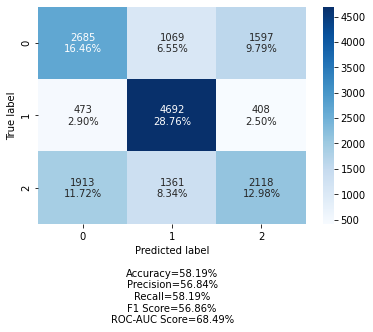

In [0]:
# MLPClassifier
print('MLPClassifier')
re_mlpc= MLPClassifier(hidden_layer_sizes=(100,),max_iter=100)
re_mlpc.fit(X_train,y_train)
pred_mlpc= re_mlpc.predict(X_val)
evaluate_model(y_val,pred_mlpc)
print(f'Training RMSE of model is: {calc_training_RMSE(X_train, y_train,re_mlpc)}')
print(f'Test RMSE of is: {calc_test_RMSE(X_val, y_val,re_mlpc)}')
conf_mlp = confusion_matrix(y_val, pred_mlpc)
make_confusion_matrix(conf_mlp,y_val,pred_mlpc)

In [0]:
# hyperpramater tuning MLPClassifier
print('MLPCLASSIFIER with hyper parameter tuning')
mlp = MLPClassifier(max_iter=200)
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,),(100,100,100)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
}

from sklearn.model_selection import GridSearchCV

clf_mlp = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf_mlp.fit(X_train, y_train)

print('Best parameters found:\n', clf_mlp.best_params_)
print('Best Score Found: \n', clf_mlp.best_score_)
print('Best estimator \n', clf_mlp.best_estimator)
# # All results
# means = clf_mlp.cv_results_['mean_test_score']
# stds = clf_mlp.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf_mlp.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

MLPCLASSIFIER with hyper parameter tuning
Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
Best Score Found: 
 0.582323076630228


AttributeError: ignored

MLPClassifier
              precision    recall  f1-score   support

           0       0.53      0.64      0.58      5351
           1       0.79      0.67      0.73      5573
           2       0.51      0.48      0.50      5392

    accuracy                           0.60     16316
   macro avg       0.61      0.60      0.60     16316
weighted avg       0.61      0.60      0.60     16316

[[3434  420 1497]
 [ 848 3734  991]
 [2237  553 2602]]
Accuracy of Model is 0.5987987251777397
Training RMSE of model is: (0.6372993555157892, 1.009887477757825)
Test RMSE of is: (0.5987987251777397, 1.0429605023504505)


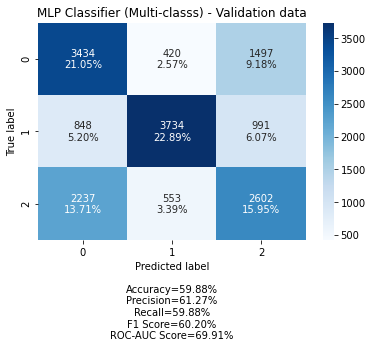

In [0]:
# MLPClassifier with params
print('MLPClassifier')
re_mlpc= MLPClassifier(hidden_layer_sizes=(100,),
                       activation='tanh',
                       alpha=0.0001, 
                       learning_rate='constant',
                       solver='adam')
re_mlpc.fit(X_train,y_train)
pred_mlpc= re_mlpc.predict(X_val)
evaluate_model(y_val,pred_mlpc)
print(f'Training RMSE of model is: {calc_training_RMSE(X_train,y_train,re_mlpc)}')
print(f'Test RMSE of is: {calc_test_RMSE(X_val, y_val,re_mlpc)}')
conf_mlp = confusion_matrix(y_val, pred_mlpc)
make_confusion_matrix(conf_mlp,y_val,pred_mlpc, title='MLP Classifier (Multi-classs) - Validation data')

In [0]:
# Save to file in the current working directory
import pickle
with open("/content/drive/My Drive/model_mlp.pkl", 'wb') as file:
    pickle.dump(re_mlpc, file)

              precision    recall  f1-score   support

           0       0.53      0.66      0.58      5310
           1       0.77      0.65      0.71      5319
           2       0.50      0.46      0.48      5367

    accuracy                           0.59     15996
   macro avg       0.60      0.59      0.59     15996
weighted avg       0.60      0.59      0.59     15996

[[3483  400 1427]
 [ 845 3482  992]
 [2286  633 2448]]
Accuracy of Model is 0.5884596149037259
Training RMSE of model is: (0.6372993555157892, 1.009887477757825)
Test RMSE of is: (0.5884596149037259, 1.0525692259865256)


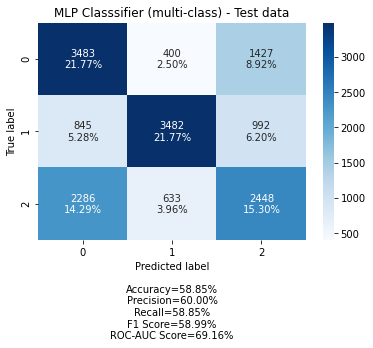

In [0]:
pred_mlpc = re_mlpc.predict(X_test)
evaluate_model(y_test,pred_mlpc)
print(f'Training RMSE of model is: {calc_training_RMSE(X_train, y_train, re_mlpc )}')
print(f'Test RMSE of is: {calc_test_RMSE(X_test, y_test, re_mlpc)}')
conf_mlp = confusion_matrix(y_test, pred_mlpc)
make_confusion_matrix(conf_mlp,y_test,pred_mlpc, title='MLP Classsifier (multi-class) - Test data')

### **Model 7: GradientBoosting Classifier**

GradientBoosting Classifier
              precision    recall  f1-score   support

           0       0.57      0.62      0.59      5351
           1       0.96      0.71      0.82      5573
           2       0.53      0.62      0.57      5392

    accuracy                           0.65     16316
   macro avg       0.69      0.65      0.66     16316
weighted avg       0.69      0.65      0.66     16316

[[3328   45 1978]
 [ 599 3953 1021]
 [1956  103 3333]]
Accuracy of Model is 0.6505270899730327
Training RMSE of model is: (0.7438074351142984, 0.8761790221377578)
Test RMSE of is: (0.6505270899730327, 1.035766365410944)


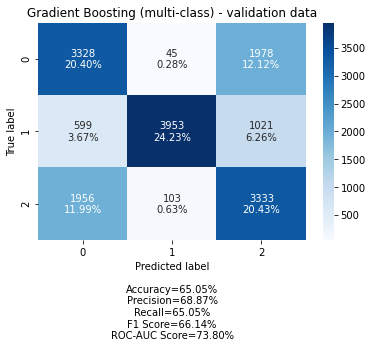

In [0]:
# GradientBoosting Classifier on validation data
print("GradientBoosting Classifier")
re_grd= GradientBoostingClassifier(max_depth=5, n_estimators=500)
re_grd.fit(X_train,y_train)
pred_grd= re_grd.predict(X_val)
evaluate_model(y_val,pred_grd)
print(f'Training RMSE of model is: {calc_training_RMSE(X_train,y_train,re_grd)}')
print(f'Test RMSE of is: {calc_test_RMSE(X_val, y_val,re_grd)}')
conf_grd= confusion_matrix(y_val,pred_grd)
make_confusion_matrix(conf_grd,y_val,pred_grd, title = 'Gradient Boosting (multi-class) - validation data')

GradientBoosting Classifier
              precision    recall  f1-score   support

           0       0.57      0.62      0.59      5310
           1       0.96      0.68      0.80      5319
           2       0.53      0.63      0.57      5367

    accuracy                           0.64     15996
   macro avg       0.68      0.64      0.65     15996
weighted avg       0.68      0.64      0.65     15996

[[3304   55 1951]
 [ 631 3623 1065]
 [1891  103 3373]]
Accuracy of Model is 0.6439109777444361
Training RMSE of model is: (0.7438074351142984, 0.8761790221377578)
Test RMSE of is: (0.6439109777444361, 1.0376146495883045)


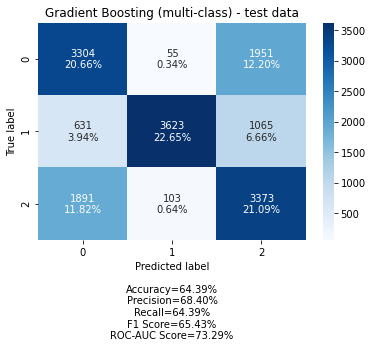

In [0]:
# GradientBoosting Classifier on test data
print("GradientBoosting Classifier")
pred_grd= re_grd.predict(X_test)
evaluate_model(y_test,pred_grd)
print(f'Training RMSE of model is: {calc_training_RMSE(X_train,y_train,re_grd)}')
print(f'Test RMSE of is: {calc_test_RMSE(X_test, y_test,re_grd)}')
conf_grd= confusion_matrix(y_test,pred_grd)
make_confusion_matrix(conf_grd,y_test,pred_grd, title = 'Gradient Boosting (multi-class) - test data')

In [0]:
# Save to file in the current working directory
import pickle
with open("/content/drive/My Drive/model_grd.pkl", 'wb') as file:
    pickle.dump(re_grd, file)

### **Model 8: SGD Classifier**

SGD Classifier
              precision    recall  f1-score   support

           0       0.39      0.84      0.53      5351
           1       0.47      0.36      0.41      5573
           2       0.46      0.04      0.08      5392

    accuracy                           0.41     16316
   macro avg       0.44      0.41      0.34     16316
weighted avg       0.44      0.41      0.34     16316

[[4479  732  140]
 [3436 1994  143]
 [3619 1532  241]]
Accuracy of Model is 0.4114979161559206
Training RMSE of model is: (0.416963793173042, 1.1366066404966713)
Test RMSE of is: (0.4114979161559206, 1.1312224066760794)


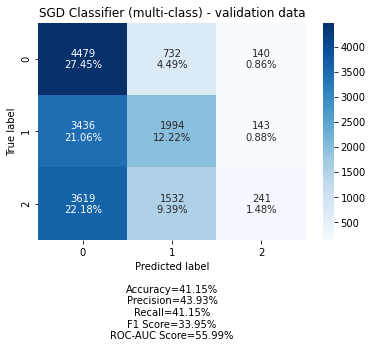

In [0]:
# SGD Classifier on validation data
print("SGD Classifier")
re_sgd= SGDClassifier(alpha=0.1, n_jobs=-1, max_iter=1500)
re_sgd.fit(X_train,y_train)
pred_sgd= re_sgd.predict(X_val)
evaluate_model(y_val,pred_sgd)
print(f'Training RMSE of model is: {calc_training_RMSE(X_train,y_train,re_sgd)}')
print(f'Test RMSE of is: {calc_test_RMSE(X_val, y_val,re_sgd)}')
conf_grd= confusion_matrix(y_val,pred_sgd)
make_confusion_matrix(conf_grd,y_val,pred_sgd, title = 'SGD Classifier (multi-class) - validation data')

SGD Classifier on test data
              precision    recall  f1-score   support

           0       0.39      0.84      0.54      5310
           1       0.46      0.36      0.40      5319
           2       0.46      0.04      0.07      5367

    accuracy                           0.41     15996
   macro avg       0.44      0.41      0.34     15996
weighted avg       0.44      0.41      0.34     15996

[[4470  709  131]
 [3281 1924  114]
 [3601 1554  212]]
Accuracy of Model is 0.4129782445611403
Training RMSE of model is: (0.416963793173042, 1.1366066404966713)
Test RMSE of is: (0.4129782445611403, 1.134436748648496)


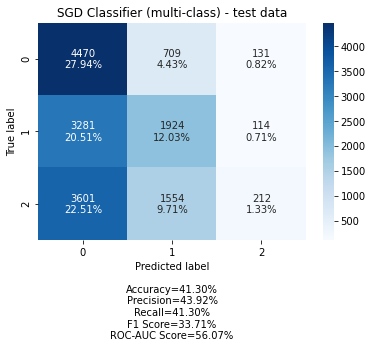

In [0]:
# SGD Classifier on test data
print("SGD Classifier on test data")
pred_sgd= re_sgd.predict(X_test)
evaluate_model(y_test,pred_sgd)
print(f'Training RMSE of model is: {calc_training_RMSE(X_train,y_train,re_sgd)}')
print(f'Test RMSE of is: {calc_test_RMSE(X_test, y_test,re_sgd)}')
conf_grd= confusion_matrix(y_test,pred_sgd)
make_confusion_matrix(conf_grd,y_test,pred_sgd, title = 'SGD Classifier (multi-class) - test data')

In [0]:
# Save to file in the current working directory
import pickle
with open("/content/drive/My Drive/model_sgd.pkl", 'wb') as file:
    pickle.dump(re_sgd, file)

### **Model : Keras Sequential**

In [0]:
#keras sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
#approach -1 (Without early stopping)
model = Sequential()
model.add(Dense(512, input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(3))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

y_train_dum = to_categorical(y_train) 
y_val_dum = to_categorical(y_val)
y_test_dum = to_categorical(y_test)
num_epochs = 100
batch_size = 128
history = model.fit(X_train, y_train_dum,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    validation_split=0.2)

#print('Validation accuracy:', acc)
predictions = model.predict(X_val)
accuracy = accuracy_score(y_val, np.argmax(predictions, axis=1))
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))

#print('Test accuracy:', acc)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, np.argmax(predictions, axis=1))
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               28672     
_________________________________________________________________
activation_16 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_17 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 3)                

In [0]:
# Save to file in the current working directory
import pickle
with open("/content/drive/My Drive/model_kerasNN.pkl", 'wb') as file:
    pickle.dump(model, file)

In [0]:
# approach -2

print('keras-tensorflow-neural network with early stopping')
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
# define baseline model

model = Sequential()
model.add(Dense(300, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(3,activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

y_train_dum = to_categorical(y_train) 
y_val_dum = to_categorical(y_val) 
y_test_dum = to_categorical(y_test)
model.compile(loss='categorical_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  
model.fit(X_train, y_train_dum, validation_data=(X_val,y_val_dum), callbacks=[monitor], verbose=2, epochs=1000)  
# score, acc = model.evaluate(X_val_b, y_val_dum,
#                       batch_size=128, verbose=2)

# print('Validation accuracy:', acc)
predictions = model.predict(X_val)
accuracy = accuracy_score(y_val, np.argmax(predictions, axis=1))
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))

#print('Test accuracy:', acc)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, np.argmax(predictions, axis=1))
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))


keras-tensorflow-neural network with early stopping
Train on 74323 samples, validate on 16316 samples
Epoch 1/1000
 - 6s - loss: 1.0533 - val_loss: 1.0389
Epoch 2/1000
 - 6s - loss: 1.0192 - val_loss: 1.0178
Epoch 3/1000
 - 6s - loss: 0.9978 - val_loss: 0.9885
Epoch 4/1000
 - 6s - loss: 0.9682 - val_loss: 0.9755
Epoch 5/1000
 - 6s - loss: 0.9313 - val_loss: 0.9212
Epoch 6/1000
 - 6s - loss: 0.8985 - val_loss: 0.8898
Epoch 7/1000
 - 6s - loss: 0.8734 - val_loss: 0.8928
Epoch 8/1000
 - 6s - loss: 0.8522 - val_loss: 0.8846
Epoch 9/1000
 - 6s - loss: 0.8378 - val_loss: 0.8571
Epoch 10/1000
 - 6s - loss: 0.8250 - val_loss: 0.8511
Epoch 11/1000
 - 6s - loss: 0.8105 - val_loss: 0.8599
Epoch 12/1000
 - 6s - loss: 0.7997 - val_loss: 0.8429
Epoch 13/1000
 - 6s - loss: 0.7902 - val_loss: 0.8685
Epoch 14/1000
 - 6s - loss: 0.7806 - val_loss: 0.8508
Epoch 00014: early stopping
Accuracy: 57.64
Accuracy: 57.14


              precision    recall  f1-score   support

           0       0.55      0.55      0.55      5310
           1       0.68      0.68      0.68      5319
           2       0.49      0.49      0.49      5367

    accuracy                           0.57     15996
   macro avg       0.57      0.57      0.57     15996
weighted avg       0.57      0.57      0.57     15996



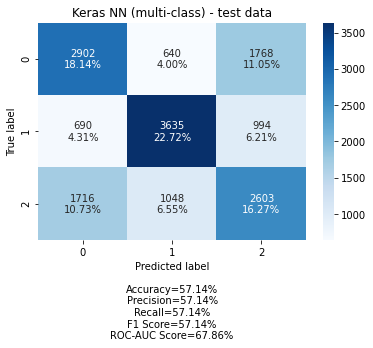

In [0]:

prediction = np.argmax(predictions, axis=1)
conf_grd= confusion_matrix(y_test,prediction)
print(classification_report(y_test,prediction))
make_confusion_matrix(conf_grd,y_test,prediction, title = 'Keras NN (multi-class) - test data')

### **Model 9: CNN**

In [0]:
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
X_train_cnn = np.expand_dims(X_train, axis=2)
X_val_cnn = np.expand_dims(X_val,axis=2)

In [0]:
X_train_cnn.shape[1]

55

In [0]:
model_cnn =  Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, input_shape=(55,1), activation='relu'))
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())

model_cnn.add(Dense(512,activation='relu',use_bias=True))
model_cnn.add(Dense(3,activation='softmax',use_bias=True))
y_train_dum = to_categorical(y_train) 
y_val_dum = to_categorical(y_val) 
y_test_dum = to_categorical(y_test)
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=0.003, patience=5, verbose=1, mode='auto')
checkpt = ModelCheckpoint(filepath='.best_weights.hdf5', verbose=0, save_best_only=True)
model_cnn.fit(X_train_cnn,y_train, validation_data=(X_val_cnn,y_val), callbacks=[monitor,checkpt], verbose =2,epochs=100)
model_cnn.load_weights('.best_weights.hdf5')

model_cnn.summary()

Epoch 1/100
2323/2323 - 27s - loss: 0.9383 - accuracy: 0.5149 - val_loss: 0.7938 - val_accuracy: 0.6103
Epoch 2/100
2323/2323 - 27s - loss: 0.7981 - accuracy: 0.5996 - val_loss: 0.7634 - val_accuracy: 0.6234
Epoch 3/100
2323/2323 - 26s - loss: 0.7832 - accuracy: 0.6076 - val_loss: 0.7706 - val_accuracy: 0.6103
Epoch 4/100
2323/2323 - 28s - loss: 0.7776 - accuracy: 0.6118 - val_loss: 0.7693 - val_accuracy: 0.6163
Epoch 5/100
2323/2323 - 26s - loss: 0.7739 - accuracy: 0.6154 - val_loss: 0.7582 - val_accuracy: 0.6224
Epoch 6/100
2323/2323 - 26s - loss: 0.7714 - accuracy: 0.6155 - val_loss: 0.7669 - val_accuracy: 0.6176
Epoch 7/100
2323/2323 - 26s - loss: 0.7691 - accuracy: 0.6158 - val_loss: 0.7624 - val_accuracy: 0.6211
Epoch 8/100
2323/2323 - 26s - loss: 0.7672 - accuracy: 0.6188 - val_loss: 0.7562 - val_accuracy: 0.6223
Epoch 9/100
2323/2323 - 26s - loss: 0.7627 - accuracy: 0.6215 - val_loss: 0.7517 - val_accuracy: 0.6255
Epoch 10/100
2323/2323 - 26s - loss: 0.7655 - accuracy: 0.6210 -

In [0]:
X_test_cnn = np.expand_dims(X_test, axis=2)

              precision    recall  f1-score   support

           0       0.56      0.58      0.57      5310
           1       0.98      0.62      0.76      5319
           2       0.50      0.66      0.57      5367

    accuracy                           0.62     15996
   macro avg       0.68      0.62      0.63     15996
weighted avg       0.68      0.62      0.63     15996



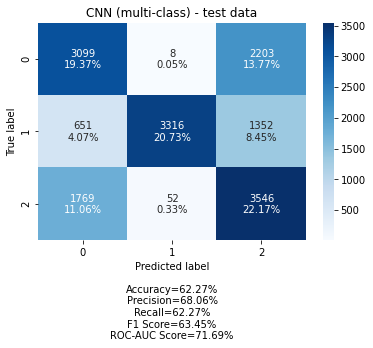

In [0]:
predictions_cnn = model_cnn.predict(X_test_cnn)
prediction = np.argmax(predictions_cnn, axis=1)
conf_cnn= confusion_matrix(y_test,prediction)
print(classification_report(y_test,prediction))
make_confusion_matrix(conf_cnn,y_test,prediction, title = 'CNN (multi-class) - test data')